In [1]:
import sys, os
import hydro
import daymetpy
import hydroeval as he
import hydrofunctions as hf
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pickle5
import requests
import warnings
import numpy as np
from pandas.tseries.frequencies import to_offset
import logging
import matplotlib
%matplotlib inline
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 14})
import matplotlib.gridspec as gridspec
import datetime
%config InlineBackend.figure_format = 'retina'
from hs_restclient import HydroShare, HydroShareAuthBasic
RID = '01cc3d5ad1a94331926d4a85553ecad2'

In [2]:
class HydroException(Exception):
    """
        This is the base class for all exceptions created for the
        HydroFunctions package. This class is not meant to be raised.
    """

    pass

class HydroNoDataError(HydroException):
    """Raised when a service returns an empty dataset or indicates that\
        it has no data for the request.
        **Usage**::
            raise HydroNoDataError("The NWIS service had no data for this request.")
        Do not catch this error for interactive sessions: The user should
        get a useful message from the error when they try to request something
        that doesn't exist.
        Catch this error in automated systems so that the system can reconsider
        the request and either fix the request or move on to the next
        request.
        **Example**::
            try:
                hf.NWIS('666666666')
            except HydroNoDataError as err:
                print("This is just to illustrate how to capture this error.")
                print(err)
    """

    pass


"""
hydrofunctions.exceptions
~~~~~~~~~~~~~~~~~~~~~~~~~
This module contains all of the custom exceptions defined in this package. The
base class is HydroException and all custom exceptions are subclasses of
HydroException.
Use the errors like this::
    try:
        #some code here that might return no data
        #more code that might get encoded improperly
    except HydroNoDataError('This site has no data'):
        # handle error here.
    except HydroEncodeError():
        # handle this error here.
    else:
        # code to complete if there is no exception raised.
    finally:
        # code that you want to run whether an exception is raised or not.
        # If an exception wasn't caught, then this code gets run, and the
        # exception gets re-raised after this finally clause gets run.
Keep the try clause short: if you put too many things in there, it can be
difficult to figure out what broke. On the other hand, like in my example
above, it is more readable if you group a series of statements and then
handle their exceptions together.
**Example:**
    >>> raise HydroNoDataError("Oh no, NWIS doesn't have this data for you!")
https://axialcorps.com/2013/08/29/5-simple-rules-for-building-great-python-packages/
-----
"""
from __future__ import absolute_import, print_function, division, unicode_literals
import warnings


class HydroException(Exception):
    """
        This is the base class for all exceptions created for the
        HydroFunctions package. This class is not meant to be raised.
    """

    pass


class HydroNoDataError(HydroException):
    """Raised when a service returns an empty dataset or indicates that\
        it has no data for the request.
        **Usage**::
            raise HydroNoDataError("The NWIS service had no data for this request.")
        Do not catch this error for interactive sessions: The user should
        get a useful message from the error when they try to request something
        that doesn't exist.
        Catch this error in automated systems so that the system can reconsider
        the request and either fix the request or move on to the next
        request.
        **Example**::
            try:
                hf.NWIS('666666666')
            except HydroNoDataError as err:
                print("This is just to illustrate how to capture this error.")
                print(err)
    """

    pass


class HydroEncodeError(HydroException):
    """Raised when an error occurs while encoding or decoding an argument.
        **Example**::
            try:
                # bunch of code from your package
            except HydroException:
                # blanked condition to handle all errors from your package
    """

    pass


class HydroUserWarning(UserWarning):
    """Warn user of a hazardous condition or when an action has been triggered\
        that may be unexpected.
        This is the base class for all warnings created for the HydroFunctions
        package. This class can be used if there is no more specific warning
        available.
        **Usage**::
            import warnings
            ... code
            warnings.warn('This is my warning message.', HydroUserWarning)
        Note:
            Warnings can be hidden or turned off depending on how the user is
            accessing Python and the settings for their interface.
            Use HydroException if a process must be shut down, or is doomed to
            fail anyway. This will at least give the user a helpful error
            message.
    """

    pass

def get_nwis(
    site,
    service="dv",
    start_date=None,
    end_date=None,
    stateCd=None,
    countyCd=None,
    bBox=None,
    parameterCd="all",
    period=None,
):
    """Request stream gauge data from the USGS NWIS.
    Args:
        site (str or list of strings):
            a valid site is '01585200' or ['01585200', '01646502']. site
            should be `None` if stateCd or countyCd are not `None`.
        service (str):
            can either be 'iv' or 'dv' for instantaneous or daily data.
                - 'dv'(default): daily values. Mean value for an entire day.
                - 'iv': instantaneous value measured at this time. Also known\
                    as 'Real-time data'. Can be measured as often as every\
                    five minutes by the USGS. 15 minutes is more typical.
        start_date (str):
           should take on the form yyyy-mm-dd
        end_date (str):
            should take on the form yyyy-mm-dd
        stateCd (str):
            a valid two-letter state postal abbreviation. Default is `None`.
        countyCd (str or list of strings):
            a valid county abbreviation. Default is `None`.
        bBox (str, list, or tuple):
            a set of coordinates that defines a bounding box.
                * Coordinates are in decimal degrees
                * Longitude values are negative (west of the prime meridian).
                * Latitude values are positive (north of the equator).
                * comma-delimited, no spaces, if provided as a string.
                * The order of the boundaries should be: "West,South,East,North"
                * Example: "-83.000000,36.500000,-81.000000,38.500000"
        parameterCd (str or list of strings):
            NWIS parameter code. Usually a five digit code. Default is 'all'.\
            A valid code can also be given as a list: ``parameterCd=['00060','00065']``
                * if value of 'all' is submitted, then NWIS will return every \
                    parameter collected at this site. (default option)
                * stage: '00065'
                * discharge: '00060'
                * not all sites collect all parameters!
                * See https://nwis.waterdata.usgs.gov/usa/nwis/pmcodes for full list
        period (str):
            NWIS period code. Default is `None`.
                * Format is "PxxD", where xx is the number of days before today.
                * Either use start_date or period, but not both.
    Returns:
        a response object. This function will always return the response,
            even if the NWIS returns a status_code that indicates a problem.
            * response.url: the url we used to request data
            * response.json: the content translated as json
            * response.status_code: the internet status code
                - '200': is a good request
                - non-200 codes will be reported as a warning.
                - '400': is a 'Bad Request'-- the parameters did not make sense
                - see <https://www.w3.org/Protocols/rfc2616/rfc2616-sec10.html> for more codes and meaning.
            * response.ok: `True` when we get a '200' status_code
    Raises:
        ConnectionError: due to connection problems like refused connection
            or DNS Error.
        SyntaxWarning: when NWIS returns a response code that is not 200.
    **Example:**
        >>> import hydrofunctions as hf
        >>> response = hf.get_nwis('01585200', 'dv', '2012-06-01', '2012-07-01')
        >>> response
        <response [200]>
        >>> response.json()
        *JSON ensues*
        >>> hf.extract_nwis_df(response)
        *a Pandas dataframe appears*
    Other Valid Ways to Make a Request::
        >>> sites = ['07180500', '03380475', '06926000'] # Request a list of sites.
        >>> service = 'iv'  # Request real-time data
        >>> days = 'P10D'  # Request the last 10 days.
        >>> stage = '00065' # Sites that collect discharge usually collect water depth too.
        >>> response2 = hf.get_nwis(sites, service, period=days, parameterCd=stage)
    Request Data By Location::
        >>> # Request the most recent daily data for every site in Maine
        >>> response3 = hf.get_nwis(None, 'dv', stateCd='ME')
        >>> response3
        <Response [200]>
    The specification for the USGS NWIS IV service is located here:
    http://waterservices.usgs.gov/rest/IV-Service.html
    """

    service = check_NWIS_service(service)

    if parameterCd == "all":
        parameterCd = None

    header = {"Accept-encoding": "gzip", "max-age": "120"}

    values = {
        # specify version of nwis json. Based on WaterML1.1
        # json,1.1 works; json%2C works; json1.1 DOES NOT WORK
        "format": "json,1.1",
        "sites": check_parameter_string(site, "site"),
        "stateCd": stateCd,
        "countyCd": check_parameter_string(countyCd, "county"),
        "bBox": check_NWIS_bBox(bBox),
        "parameterCd": check_parameter_string(parameterCd, "parameterCd"),
        "period": period,
        "startDT": start_date,
        "endDT": end_date,
    }

#     # Check that site selection parameters are exclusive!
#     total = count_number_of_truthy([site, stateCd, countyCd, bBox])
#     if total == 1:
#         pass
#     elif total > 1:
#         raise ValueError(
#             "Select sites using either site, stateCd, "
#             "countyCd, or bBox, but not more than one."
#         )
#     elif total < 1:
#         raise ValueError(
#             "Select sites using at least one of the following "
#             "arguments: site, stateCd, countyCd or bBox."
#         )

    # Check that time parameters are not both set.
    # If neither is set, then NWIS will return the most recent observation.
    if start_date and period:
        raise ValueError(
            "Use either start_date or period, or neither, " "but not both."
        )

    if not (start_date or period):
        # User didn't specify time; must be requesting most recent data.
        # See issue #49.
        pass

    url = "https://waterservices.usgs.gov/nwis/"
    url = url + service + "/?"
    response = requests.get(url, params=values, headers=header)
    print("Requested data from", response.url)
    # requests will raise a 'ConnectionError' if the connection is refused
    # or if we are disconnected from the internet.

    # .get_nwis() will always return the response.

    # Higher-level code that calls get_nwis() may decide to handle or
    # report status codes that indicate something went wrong.

    # Issue warnings for bad status codes
    nwis_custom_status_codes(response)
    if not response.text:
        raise HydroNoDataError(
            "The NWIS has returned an empty string for this request."
        )

    return response

def check_NWIS_service(input):
    """Checks that the service is valid: either 'iv' or 'dv'"""
    if input is None:
        return None
    if input == "iv" or input == "dv":
        return input
    else:
        raise TypeError(
            "The NWIS service type accepts 'dv' for daily values, "
            "or 'iv' for instantaneous values. Actual value: "
            "{}".format(input)
        )
        
def check_parameter_string(candidate, param):
    """Checks that a parameter is a string or a list of strings.
    """
    parameters = {
        "site": "NWIS station id(s) should be a string or list of strings,"
        + "often in the form of an eight digit number enclosed in quotes.",
        "parameterCd": "NWIS parameter codes are five-digit strings that specify "
        + "the parameter that is being measured at the site. Common "
        + "codes are '00060' for stream stage in feet, '00065' for "
        + "stream discharge in cubic feet per second, and '72019' for "
        + "groundwater levels. Not all sites collect data for all "
        + "parameters. See a complete list of physical parameters here: "
        + "https://help.waterdata.usgs.gov/parameter_cd?group_cd=PHY "
        + "You may request multiple parameters by submitting a comma-"
        + "delimited string of codes with no spaces, or by submitting "
        + "a list of codes, like this: parameterCd = '00065,00060' or "
        + "parameterCd = ['00065', '00060'] ",
        "county": "The NWIS county parameter accepts a five-digit string or "
        + "a list of five-digit strings to select all of the sites "
        + "within a county or list of counties. "
        + "Example: '51059' or ['51059', '51061'] are acceptable.",
        "state": "This parameter uses US two-letter postal codes "
        + "such as 'MD' for Maryland or 'AZ' for Arizona.",
        "default": "This parameter should be a string or a list of strings.",
    }
    if param in parameters:
        msg = parameters[param] + " Actual value: {}".format(candidate)
    else:
        msg = (
            "This parameter should be a string or a list of strings."
            + " Actual value: {}".format(candidate)
        )

    if candidate is None:
        return None
    elif isinstance(candidate, str) and candidate:
        return candidate
    elif (isinstance(candidate, list) or isinstance(candidate, tuple)) and candidate:
        for s in candidate:
            if not isinstance(s, str):
                raise TypeError(msg + "   bad element: {}".format(s))
        return ",".join([str(s) for s in candidate])
    else:
        raise TypeError(msg)
        
def check_NWIS_bBox(input):
    """Checks that the USGS bBox is valid.
    """
    msg = (
        "NWIS bBox should be a string, list of strings, or tuple "
        + "containing the longitude and latitude of the lower left corner "
        + "of the bounding box, followed by the longitude and latitude "
        + "of the upper right corner of the bounding box. Most often in "
        + 'the form of "ll_long,ll_lat,ur_long,ur_lat" . '
        + "All latitude and longitude values should have less than 8 "
        + "places. "
        + "Actual value: {}".format(input)
    )
    if input is None:
        return None
    # assume that if it is a string it will be fine as is.
    # don't accept a series of sites in a single string.
    # Test for and reject empty strings: empty strings are false.
    if isinstance(input, str) and input:
        t = input.split(",")
        if len(t) < 4:
            raise TypeError(msg)
        return input
    # test for input is a list and it is not empty
    elif (isinstance(input, list) or isinstance(input, tuple)) and input:
        if len(input) < 4:
            raise TypeError(msg)
        # format:  [-83.000000, 36.500000, -81.000000, 38.500000] ==> '-83.000000,36.500000,-81.000000,38.500000'
        return ",".join([str(s) for s in input])
    else:
        raise TypeError(msg)

def count_number_of_truthy(my_list):
    return sum(bool(item) for item in my_list)

def nwis_custom_status_codes(response):
    """
    Raise custom warning messages from the NWIS when it returns a
    status_code that is not 200.
    Args:
        response: a response object as returned by get_nwis().
    Returns:
        * `None`
            if response.status_code == 200
        * `response.status_code`
            for all other status codes.
    Raises:
        SyntaxWarning: when a non-200 status code is returned.
            https://en.wikipedia.org/wiki/List_of_HTTP_status_codes
    Note:
        To raise an exception, call ``response.raise_for_status()``
        This will raise `requests.exceptions.HTTPError` with a helpful message
        or it will return `None` for status code 200.
        From: http://docs.python-requests.org/en/master/user/quickstart/#response-status-codes
        NWIS status_code messages come from:
            https://waterservices.usgs.gov/docs/portable_code.html
        Additional status code documentation:
            https://waterservices.usgs.gov/rest/IV-Service.html#Error
    """
    nwis_msg = {
        "200": "OK",
        "400": "400 Bad Request - "
        "This often occurs if the URL arguments "
        "are inconsistent. For example, if you submit a request using "
        "a startDT and an endDT with the period argument. "
        "An accompanying error should describe why the request was "
        "bad." + "\nError message from NWIS: {}".format(response.reason),
        "403": "403 Access Forbidden - "
        "This should only occur if for some reason the USGS has "
        "blocked your Internet Protocol (IP) address from using "
        "the service. This can happen if we believe that your use "
        "of the service is so excessive that it is seriously "
        "impacting others using the service. To get unblocked, "
        "send us the URL you are using along with the IP using "
        "this form. We may require changes to your query and "
        "frequency of use in order to give you access to the "
        "service again.",
        "404": "404 Not Found - "
        "Returned if and only if the query expresses a combination "
        "of elements where data do not exist. For multi-site "
        "queries, if any data are found, it is returned for those "
        "site/parameters/date ranges where there are data.",
        "503": "500 Internal Server Error - "
        "If you see this, it means there is a problem with the web "
        "service itself. It usually means the application server "
        "is down unexpectedly. This could be caused by a host of "
        "conditions, but changing your query will not solve this "
        "problem. The NWIS application support team has to fix it. Most "
        "of these errors are quickly detected and the support team "
        "is notified if they occur.",
    }
    if response.status_code == 200:
        return None
    # All other status codes will raise a warning.
    else:
        # Use the status_code as a key, return None if key not in dict
        msg = (
            "The NWIS returned a code of {}.\n".format(response.status_code)
            + nwis_msg.get(str(response.status_code))
            + "\n\nURL used in this request: {}".format(response.url)
        )

        # Warnings will not beak the flow. They just print a message.
        # However, they are often supressed in some applications.
        warnings.warn(msg, SyntaxWarning)
        return response.status_code
    
def extract_nwis_df(nwis_dict, interpolate=True):
    """Returns a Pandas dataframe and a metadata dict from the NWIS response
    object or the json dict of the response.
    Args:
        nwis_dict (obj):
            the json from a response object as returned by get_nwis().json().
            Alternatively, you may supply the response object itself.
    Returns:
        a pandas dataframe.
    Raises:
        HydroNoDataError
            when the request is valid, but NWIS has no data for
            the parameters provided in the request.
        HydroUserWarning
            when one dataset is sampled at a lower frequency than
            another dataset in the same request.
    """
    if type(nwis_dict) is not dict:
        nwis_dict = nwis_dict.json()

    # strip header and all metadata.
    ts = nwis_dict["value"]["timeSeries"]
    if ts == []:
        # raise a HydroNoDataError if NWIS returns an empty set.
        #
        # Ideally, an empty set exception would be raised when the request
        # is first returned, but I do it here so that the data doesn't get
        # extracted twice.
        # TODO: raise this exception earlier??
        #
        # ** Interactive sessions should have an error raised.
        #
        # **Automated systems should catch these errors and deal with them.
        # In this case, if NWIS returns an empty set, then the request
        # needs to be reconsidered. The request was valid somehow, but
        # there is no data being collected.

        raise HydroNoDataError(
            "The NWIS reports that it does not " "have any data for this request."
        )

    # create a list of time series;
    # set the index, set the data types, replace NaNs, sort, find the first and last

    collection = []
    starts = []
    ends = []
    freqs = []
    meta = {}
    for series in ts:
        series_name = series["name"]
        temp_name = series_name.split(":")
        agency = str(temp_name[0])
        site_id = agency + ":" + str(temp_name[1])
        parameter_cd = str(temp_name[2])
        stat = str(temp_name[3])
        siteName = series["sourceInfo"]["siteName"]
        siteLatLongSrs = series["sourceInfo"]["geoLocation"]["geogLocation"]
        noDataValues = series["variable"]["noDataValue"]
        variableDescription = series["variable"]["variableDescription"]
        unit = series["variable"]["unit"]["unitCode"]
        data = series["values"][0]["value"]
        if data == []:
            # This parameter has no data. Skip to next series.
            continue
        if len(data) == 1:
            # This parameter only contains the most recent reading.
            # See Issue #49
            pass
        qualifiers = series_name + "_qualifiers"
        DF = pd.DataFrame(data=data)
        DF.index = pd.to_datetime(DF.pop("dateTime"), utc=True)
        DF["value"] = DF["value"].astype(float)
        DF = DF.replace(to_replace=noDataValues, value=np.nan)
        DF["qualifiers"] = DF["qualifiers"].apply(lambda x: ",".join(x))
        DF.rename(
            columns={"qualifiers": qualifiers, "value": series_name}, inplace=True
        )
        DF.sort_index(inplace=True)
        local_start = DF.index.min()
        local_end = DF.index.max()
        starts.append(local_start)
        ends.append(local_end)
        local_freq = calc_freq(DF.index)
        freqs.append(local_freq)
        if not DF.index.is_unique:
            print(
                "Series index for "
                + series_name
                + " is not unique. Attempting to drop identical rows."
            )
            DF = DF.drop_duplicates(keep="first")
            if not DF.index.is_unique:
                print(
                    "Series index for "
                    + series_name
                    + " is STILL not unique. Dropping first rows with duplicated date."
                )
                DF = DF[~DF.index.duplicated(keep="first")]
        if local_freq > to_offset("0min"):
            local_clean_index = pd.date_range(
                start=local_start, end=local_end, freq=local_freq, tz="UTC"
            )
            # if len(local_clean_index) != len(DF):
            # This condition happens quite frequently with missing data.
            # print(str(series_name) + "-- clean index length: "+ str(len(local_clean_index)) + " Series length: " + str(len(DF)))
            DF = DF.reindex(index=local_clean_index, copy=True)
        else:
            # The dataframe DF must contain only the most recent data.
            pass
        qual_cols = DF.columns.str.contains("_qualifiers")
        # https://stackoverflow.com/questions/21998354/pandas-wont-fillna-inplace
        # Instead, create a temporary dataframe, fillna, then copy back into original.
        DFquals = DF.loc[:, qual_cols].fillna("hf.missing")
        DF.loc[:, qual_cols] = DFquals

        if local_freq > pd.Timedelta(to_offset("0min")):
            variableFreq_str = str(to_offset(local_freq))
        else:
            variableFreq_str = str(to_offset("0min"))
        parameter_info = {
            "variableFreq": variableFreq_str,
            "variableUnit": unit,
            "variableDescription": variableDescription,
        }
        site_info = {
            "siteName": siteName,
            "siteLatLongSrs": siteLatLongSrs,
            "timeSeries": {},
        }
        # if site is not in meta keys, add it.
        if site_id not in meta:
            meta[site_id] = site_info
        # Add the variable info to the site dict.
        meta[site_id]["timeSeries"][parameter_cd] = parameter_info
        collection.append(DF)

    if len(collection) < 1:
        # It seems like this condition should not occur. The NWIS trims the
        # response and returns an empty nwis_dict['value']['timeSeries']
        # if none of the parameters requested have data.
        # If at least one of the paramters have data,
        # then the empty series will get delivered, but with no data.
        # Compare these requests:
        # empty:               https://nwis.waterservices.usgs.gov/nwis/iv/?format=json&sites=01570500&startDT=2018-06-01&endDT=2018-06-01&parameterCd=00045
        # one empty, one full: https://nwis.waterservices.usgs.gov/nwis/iv/?format=json&sites=01570500&startDT=2018-06-01&endDT=2018-06-01&parameterCd=00045,00060
        raise HydroNoDataError(
            "The NWIS does not have any data for"
            " the requested combination of sites"
            ", parameters, and dates."
        )
    startmin = min(starts)
    endmax = max(ends)
    # Remove all frequencies of zero from freqs list.
    zero = to_offset("0min")
    freqs2 = list(filter(lambda x: x > zero, freqs))
    if len(freqs2) > 0:
        freqmin = min(freqs2)
        freqmax = max(freqs2)
        if freqmin != freqmax:
            warnings.warn(
                "One or more datasets in this request is going to be "
                "'upsampled' to " + str(freqmin) + " because the data "
                "were collected at a lower frequency of " + str(freqmax),
                HydroUserWarning,
            )

        clean_index = pd.date_range(start=startmin, end=endmax, freq=freqmin, tz="UTC")
        cleanDF = pd.DataFrame(index=clean_index)
        for dataset in collection:
            cleanDF = pd.concat([cleanDF, dataset], axis=1)
        # Replace lines with missing _qualifier flags with hf.upsampled
        qual_cols = cleanDF.columns.str.contains("_qualifiers")
        cleanDFquals = cleanDF.loc[:, qual_cols].fillna("hf.upsampled")
        cleanDF.loc[:, qual_cols] = cleanDFquals
        if interpolate:
            # TODO: mark interpolated values with 'hf.interp'
            # select data, then replace Nans with interpolated values.
            data_cols = cleanDF.columns.str.contains(r"[0-9]$")
            cleanDFdata = cleanDF.loc[:, data_cols].interpolate()
            cleanDF.loc[:, data_cols] = cleanDFdata
    else:
        # If datasets only contain most recent data, then
        # don't set an index or a freq. Just concat all of the datasets.
        cleanDF = pd.concat(collection, axis=1)

    cleanDF.index.name = "datetimeUTC"

    if not DF.index.is_unique:
        DF = DF[~DF.index.duplicated(keep="first")]
    if not DF.index.is_monotonic:
        DF.sort_index(axis=0, inplace=True)

    return cleanDF, meta

def calc_freq(index):
    # Method 0: calc_freq() was called, but we haven't done anything yet.
    method = 0
    if isinstance(index, pd.DataFrame):
        index = index.index
    try:
        # Method 1: Try the direct approach first. Maybe freq has already been set.
        freq = index.freq
        method = 1
    except AttributeError:
        # index.freq does not exist, so let's keep trying.
        freq = None

    if freq is None:
        # Method 2: Use the built-in pd.infer_freq(). It raises ValueError
        #    when it fails, so catch ValueErrors and keep trying.
        try:
            freq = to_offset(pd.infer_freq(index))
            method = 2
        except ValueError:
            pass

    if freq is None:
        # Method 3: divide the length of time by the number of observations.
        freq = (index.max() - index.min()) / len(index)
        if pd.Timedelta("13 minutes") < freq < pd.Timedelta("17 minutes"):
            freq = to_offset("15min")
        elif pd.Timedelta("27 minutes") < freq < pd.Timedelta("33 minutes"):
            freq = to_offset("30min")
        elif pd.Timedelta("55 minutes") < freq < pd.Timedelta("65 minutes"):
            freq = to_offset("60min")
        else:
            freq = None
        method = 3

    if freq is None:
        # Method 4: Subtract two adjacent values and use the difference!
        if len(index) > 3:
            freq = to_offset(abs(index[2] - index[3]))
            method = 4
            logging.debug(
                "calc_freq4:"
                + str(freq)
                + "= index[2]:"
                + str(index[3])
                + "- index [3]:"
                + str(index[2])
            )

    if freq is None:
        # Method 5: If all else fails, freq is 0 minutes!
        warnings.warn(
            "It is not possible to determine the frequency "
            "for one of the datasets in this request. "
            "This dataset will be set to a frequency of "
            "0 minutes",
            HydroUserWarning,
        )

        freq = to_offset("0min")
        method = 5

    debug_msg = "Calc_freq method:" + str(method) + "freq:" + str(freq)
    logging.debug(debug_msg)
    return pd.Timedelta(freq)

In [3]:
def NSE(simulated, observed):
    nse = 1-np.nansum((simulated-observed)**2)/np.nansum((observed-np.nanmean(observed))**2)
    return nse

def KGE(simulated, observed):
    sim_mean = np.mean(simulated, axis=0)
    obs_mean = np.mean(observed)

    r_num = np.sum((simulated - sim_mean) * (observed - obs_mean),
                   axis=0)
    r_den = np.sqrt(np.sum((simulated - sim_mean) ** 2,
                           axis=0)
                    * np.sum((observed - obs_mean) ** 2))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulated, axis=0) / np.std(observed)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulated, axis=0)
            / np.sum(observed))
    # calculate the Kling-Gupta Efficiency KGE
    kge_ = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

    return (kge_, r, alpha, beta)

def RMSE(simulated, observed):
    rmse_ = np.sqrt(np.nanmean((observed - simulated) ** 2))
    return rmse_

def MARE(simulations, evaluation):
    mare_ = (np.sum(np.abs(evaluation - simulations), axis=0,)
             / np.sum(evaluation))
    return mare_

def Pbias(simulations, evaluation):
    pbias_ = (100 * np.sum(evaluation - simulations, axis=0)
              / np.sum(evaluation))
    return pbias_

def evaluate_performance(simulated, observed):
    nse = NSE(simulated,observed)
    kge, r, alpha, beta = KGE(simulated, observed)
    rmse = RMSE(simulated, observed)
    mare = MARE(simulated, observed)
    pbias = Pbias(simulated, observed)
    performance_dict = {'NSE':[nse], 'KGE':[(kge, r, alpha, beta)],
                       'RMSE':[rmse], 'MARE':[mare], 'Pbias':[pbias]}
    performance_df = pd.DataFrame.from_dict(performance_dict)
    return performance_df

def find_best(performance_df):
    best_nse = performance_df[performance_df.NSE>0.9*np.nanmax(performance_df.NSE)]
    best_nse_kge = best_nse[best_nse.KGE_only>0.9*np.nanmax(performance_df.KGE_only)]
    if len(best_nse_kge)==0:
        best_use = best_nse
        print('no good KGE, NSE overlap')
    else:
        best_nse_kge_rmse = best_nse_kge[best_nse_kge.RMSE<1.1*np.nanmin(performance_df.RMSE)]
        if len(best_nse_kge_rmse)==0:
            best_use = best_nse_kge
            print('no good KGE, NSE, RMSE overlap')
        else:
            best_nse_kge_rmse_mare = best_nse_kge_rmse[best_nse_kge_rmse.MARE<1.1*np.nanmin(performance_df.MARE)]
            if len(best_nse_kge_rmse_mare)==0:
                best_use = best_nse_kge_rmse
                print('no good KGE, NSE, RMSE, MARE overlap')
            else:
                best_use = best_nse_kge_rmse_mare
    return best_use

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
# put in hydroshare credentials if you don't have data yet
# auth = HydroShareAuthBasic(username='username', password='password')
# hs = HydroShare(auth=auth)

In [5]:
# gridmet_tmin = pd.read_csv('../Data/bigfiles/gridmet_Tmin_K_all_CONUS_gages.csv')
# gridmet_tmax = pd.read_csv('../Data/bigfiles/gridmet_Tmax_K_all_CONUS_gages.csv')
# gridmet_prcp = pd.read_csv('../Data/bigfiles/gridmet_P_mm_all_CONUS_gages2.csv')
# gridmet_tmin = gridmet_tmin.set_index(pd.to_datetime(gridmet_tmin['date'])).drop(columns='date')
# gridmet_tmin = gridmet_tmin - 273.15 
# gridmet_tmax = gridmet_tmax.set_index(pd.to_datetime(gridmet_tmax['date'])).drop(columns='date')
# gridmet_tmax = gridmet_tmax - 273.15 
# gridmet_prcp = gridmet_prcp.set_index(pd.to_datetime(gridmet_prcp['date'])).drop(columns='date')

In [6]:
# try:
#     os.mkdir('../Data/bigfiles')
# except:
#     print('bigfiles directory exists')
# try:
#     gridmet_tmin = pd.read_csv('../Data/bigfiles/gridmet_Tmin_K_all_CONUS_gages.csv')
#     gridmet_tmax = pd.read_csv('../Data/bigfiles/gridmet_Tmax_K_all_CONUS_gages.csv')
#     gridmet_prcp = pd.read_csv('../Data/bigfiles/gridmet_P_mm_all_CONUS_gages2.csv')
# except:
#     files = ['gridmet_Tmin_K_all_CONUS_gages.csv',
#             'gridmet_Tmax_K_all_CONUS_gages.csv',
#             'gridmet_P_mm_all_CONUS_gages2.csv']
#     for f in files:
#          fpath = hs.getResourceFile(RID, f, destination='../Data/bigfiles')
#     gridmet_tmin = pd.read_csv('../Data/bigfiles/gridmet_Tmin_K_all_CONUS_gages.csv')
#     gridmet_tmax = pd.read_csv('../Data/bigfiles/gridmet_Tmax_K_all_CONUS_gages.csv')
#     gridmet_prcp = pd.read_csv('../Data/bigfiles/gridmet_P_mm_all_CONUS_gages2.csv')
    

# gridmet_tmin = gridmet_tmin.set_index(pd.to_datetime(gridmet_tmin['date'])).drop(columns='date')
# gridmet_tmin = gridmet_tmin - 273.15 
# gridmet_tmax = gridmet_tmax.set_index(pd.to_datetime(gridmet_tmax['date'])).drop(columns='date')
# gridmet_tmax = gridmet_tmax - 273.15 
# gridmet_prcp = gridmet_prcp.set_index(pd.to_datetime(gridmet_prcp['date'])).drop(columns='date')

In [7]:
gridmet_tmin = pd.read_csv('../Data/gridmet_tempsites/gridmet_Tmin_C_15yr_temp_gages.csv')
gridmet_tmin['date'] = pd.to_datetime(gridmet_tmin['date'])
gridmet_tmin = gridmet_tmin.set_index('date')

gridmet_tmax = pd.read_csv('../Data/gridmet_tempsites/gridmet_Tmax_C_15yr_temp_gages.csv')
gridmet_tmax['date'] = pd.to_datetime(gridmet_tmax['date'])
gridmet_tmax = gridmet_tmax.set_index('date')

gridmet_prcp = pd.read_csv('../Data/gridmet_tempsites/gridmet_P_mm_15yr_temp_gages.csv')
gridmet_prcp['date'] = pd.to_datetime(gridmet_prcp['date'])
gridmet_prcp = gridmet_prcp.set_index('date')

In [8]:
record_length = pd.read_csv('../Data/gagesII_data_and_subsets/record_length_yrs.csv')
gagesII = gpd.read_file('../Data/gagesII_data_and_subsets/gagesII.shp')
# gagesII = gpd.read_file('../Data/bigfiles/gagesII_9322_point_shapefile/gagesII_9322_sept30_2011.shp')

In [9]:
# # groundwater temperature offset (https://iopscience.iop.org/article/10.1088/1748-9326/aa5fb0#erlaa5fb0s9)
# # this is offset from LST, but LST is within a couple degrees of surface temperature
# # https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JD026880

# import rasterio
# gw = rasterio.open('../Data/Raster_data/DT_total.tif')


In [10]:
# fig,ax = plt.subplots(1)
# plt.imshow(gw.read(1))
# # 
# plt.colorbar()
# state_outline.to_crs('EPSG:4326').plot(ax=ax,alpha=0.2)

In [11]:
# print('total',len(gagesII))
# gagesII = gagesII.to_crs('EPSG:4326')
# gwT = []
# for i in range(len(gagesII)):
#     print(i)
#     try:
#         xycoord = gw.index(gagesII.geometry.centroid.x.values[i],
#                gagesII.geometry.centroid.y.values[i])
#         gwT.append(gw.read(1)[xycoord[0],xycoord[1]])
#     except:
#         gwT.append(np.nan)

In [12]:
# gagesII['gwT_offset'] = gwT

In [13]:
def streamT(X, a, b, c):
    airT, Q = X
    return a*airT + b*Q + c

In [35]:
limit=15
rlen = record_length[record_length.record_length_yr>limit]
errorsites = []

print('total: ',len(rlen))
for k in range(len(rlen)):
    sitenum = str(int(rlen.iloc[k].site))
    while len(sitenum)<8:
        sitenum = '0'+sitenum
    print('')
    print(k, sitenum)
    
    # download streamflow and water temperature data from NWIS
    try:
        state_temp= get_nwis(site=sitenum, service='iv', start_date='1950-01-01', end_date='2020-12-31',
                        parameterCd = '00010')
        state_temp = extract_nwis_df(state_temp)
        state_temp_meta = state_temp[1]
        state_temp = state_temp[0]
        state_temp = state_temp.rename(columns = {list(state_temp.columns)[0]:'temperature_C',
                                  list(state_temp.columns)[1]:'qualifiers'})

        state_data = get_nwis(site=sitenum, service='iv', start_date=str(state_temp.index[0])[:10], 
                              end_date=str(state_temp.index[-1])[:10],parameterCd = '00060')
        state_data = extract_nwis_df(state_data)
        state_data_meta = state_data[1]
        state_data = state_data[0]
        state_data = state_data.rename(columns = {list(state_data.columns)[0]:'discharge_cfs',
                                      list(state_data.columns)[1]:'qualifiers'})
        state_data = state_data.merge(state_temp,left_index=True, right_index=True)
    except:
        state_data = 'rats'
    if (len(state_data)==0) | (type(state_data) ==type('rats')):
        print('no data')
        errorsites.append(sitenum)
    else:
        state_data_day = state_data.resample('1D').mean()
        state_data_day['Tmin_water'] = state_data.temperature_C.resample('D').min()
        state_data_day['Tmax_water'] = state_data.temperature_C.resample('D').max()
        state_data_day = state_data_day.tz_convert(None)

        # call in gridmet data
        start = (state_temp.index[0]).tz_convert(None)
        end = (state_temp.index[-1]).tz_convert(None)
        if (pd.to_datetime('12-02-2020')-end).days<0:
            end = pd.to_datetime('12-02-2020')
        if (sitenum in gridmet_tmin.columns):
            site_gridmet_tmin = gridmet_tmin.rename(columns={sitenum:'tmin'})['tmin']
            site_gridmet_tmax = gridmet_tmax.rename(columns={sitenum:'tmax'})['tmax']
            try:
                site_gridmet_prcp = gridmet_prcp.rename(columns={sitenum[1:]:'prcp'})['prcp']
            except:
                site_gridmet_prcp = gridmet_prcp.rename(columns={sitenum:'prcp'})['prcp']
            site_gridmet = pd.DataFrame(site_gridmet_tmin).merge(site_gridmet_tmax,left_index=True,right_index=True)
            site_gridmet = site_gridmet.merge(site_gridmet_prcp,left_index=True,right_index=True)
            site_gridmet = site_gridmet.loc[start:end]
            state_data_day = state_data_day.merge(site_gridmet,left_index=True,right_index=True)        

            hotmonths = [7,8,9,10]
            springmonths = [3,4,5,6]
            state_data_day_sub = state_data_day.reset_index()[(state_data_day.reset_index()['index'].dt.month.isin(hotmonths))].set_index('index')
            state_data_day_sub0 = state_data_day.reset_index()[(state_data_day.reset_index()['index'].dt.month.isin(springmonths))].set_index('index')
            state_data_day_sub1 = state_data_day.reset_index()[~(state_data_day.reset_index()['index'].dt.month.isin(hotmonths+springmonths))].set_index('index')

            cutoff_date = state_data_day.index.values[len(state_data_day)//2]

            popt_mean, pcov_mean = curve_fit(streamT,
                                            (state_data_day_sub[['tmin','tmax']].loc[:cutoff_date].mean(axis=1),
                                             state_data_day_sub.loc[:cutoff_date].discharge_cfs),
                                            state_data_day_sub.loc[:cutoff_date][['Tmin_water','Tmax_water']].mean(axis=1))
            popt_spring, pcov_spring = curve_fit(streamT,
                                            (state_data_day_sub0.loc[:cutoff_date][['tmin','tmax']].mean(axis=1),
                                             state_data_day_sub0.loc[:cutoff_date].discharge_cfs),
                                            state_data_day_sub0.loc[:cutoff_date][['Tmin_water','Tmax_water']].mean(axis=1))
            popt_yr, pcov_yr = curve_fit(streamT,
                                            (state_data_day_sub1.loc[:cutoff_date][['tmin','tmax']].mean(axis=1),
                                             state_data_day_sub1.loc[:cutoff_date].discharge_cfs),
                                            state_data_day_sub1.loc[:cutoff_date][['Tmin_water','Tmax_water']].mean(axis=1))
            modeled_water_yr = streamT((state_data_day.tmin,state_data_day.discharge_cfs),
                                   *popt_yr)
            modeled_water_tmean = streamT((state_data_day[['tmin','tmax']].mean(axis=1),state_data_day.discharge_cfs),
                                   *popt_mean)
            modeled_water_spring = streamT((state_data_day[['tmin','tmax']].mean(axis=1),state_data_day.discharge_cfs),
                                   *popt_spring)
            state_data_day['Tmean_modeled_yr'] = modeled_water_yr
            state_data_day['Tmean_modeled_summer'] = modeled_water_tmean
            state_data_day['Tmean_modeled_spring'] = modeled_water_spring
            state_data_day['Tmean_modeled'] = np.where(state_data_day.reset_index()['index'].dt.month.isin(hotmonths),
                                                      state_data_day.Tmean_modeled_summer,
                                                      state_data_day.Tmean_modeled_yr)
            state_data_day['Tmean_modeled'] = np.where(state_data_day.reset_index()['index'].dt.month.isin(springmonths),
                                                      state_data_day.Tmean_modeled_spring,
                                                      state_data_day.Tmean_modeled)
            kge_curr = KGE(state_data_day.loc[cutoff_date:].Tmean_modeled,
                           state_data_day.loc[cutoff_date:][['Tmin_water','Tmax_water']].mean(axis=1))[0]
            nse_curr = NSE(state_data_day.loc[cutoff_date:].Tmean_modeled,
                           state_data_day.loc[cutoff_date:][['Tmin_water','Tmax_water']].mean(axis=1))
            
            print('KGE:',kge_curr)
            print('NSE:', nse_curr)

            save_best_info = {'KGE':[kge_curr], 'NSE':[nse_curr], 'sitenum':[sitenum],
                              'summer_params':[popt_mean], 'winter_params':[popt_yr],
                             'spring_params':[popt_spring]}

            if k==0:
                best_info_total = pd.DataFrame.from_dict(save_best_info)
            else:
                best_info_total = pd.concat([best_info_total,
                                            pd.DataFrame.from_dict(save_best_info)])
        else:
            print('no gridmet data')
            errorsites.append(sitenum)


total:  311

0 02423130
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02423130&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02423130&parameterCd=00060&startDT=2007-10-23&endDT=2020-12-27
KGE: 0.8299322349900184
NSE: 0.6439396611254943

1 02423496
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02423496&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02423496&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.8761054725551508
NSE: 0.8425279057659469

2 02455980
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02455980&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=0245598

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11276600&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.8438467902665922
NSE: 0.7027687714311245

27 11289650
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11289650&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11289650&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.5840299730466387
NSE: 0.050663991229173755

28 11302000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11302000&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11302000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
no data

29 11303000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=113030

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=06711565&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=06711565&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.8610184214674745
NSE: 0.8743613838548223

61 07086000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=07086000&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=07086000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
no data

62 07096000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=07096000&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=07096000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
no dat

KGE: 0.455599322587782
NSE: -0.005432459219107955

84 02310650
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02310650&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02310650&parameterCd=00060&startDT=2007-10-13&endDT=2021-01-01
KGE: 0.6705421908037956
NSE: 0.4708585919983459

85 02310700
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02310700&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02310700&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.7123956881433571
NSE: 0.644157337637738

86 02310747
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02310747&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/

KGE: 0.8404479366190483
NSE: 0.8334968745744412

107 02336240
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02336240&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02336240&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.8243017540375539
NSE: 0.8343173482682483

108 02336300
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02336300&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02336300&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.8347998128430622
NSE: 0.84426956143224

109 02336360
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02336360&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/

KGE: 0.8903342732969688
NSE: 0.8924079539712586

133 01104430
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01104430&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01104430&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.9157958772356289
NSE: 0.8624767762200366

134 01104460
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01104460&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01104460&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.9002890349919848
NSE: 0.8896090841056717

135 01104475
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01104475&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.go

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=06465500&parameterCd=00060&startDT=2010-10-11&endDT=2021-01-01
KGE: 0.6748728902502632
NSE: 0.3259127314031989

156 06775500
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=06775500&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
no data

157 06881000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=06881000&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
no data

158 10301500
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=10301500&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=10301500&parameterCd=00060&startDT=2012-02-06&endDT=2021-01-01
KGE: -3.320040748231654
NSE: -31.959318726878898

159 10348200
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=07177500&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.8028155488059405
NSE: 0.7823416672790356

182 07178200
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=07178200&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=07178200&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.7145354005219433
NSE: 0.3880283638677525

183 07239450
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=07239450&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=07239450&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.8757648703082512
NSE: 0.8473970603493659

184 07239700
Requested data from https://nwis.waterservices.usgs.go

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14150800&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14150800&parameterCd=00060&startDT=2008-11-13&endDT=2021-01-01
KGE: 0.8864446335644559
NSE: 0.7896658605527722

206 14151000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14151000&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14151000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.7204408731737315
NSE: 0.5171416060952373

207 14152000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14152000&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14152000&parameterCd=00060&

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14206950&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14206950&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.8841026460567474
NSE: 0.8337611693001181

229 14211010
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14211010&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14211010&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.8980460937258403
NSE: 0.8502539412981025

230 14211400
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14211400&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14211400&parameterCd=00060&

KGE: 0.8729769533982341
NSE: 0.8385351710649293

254 01449360
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01449360&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01449360&parameterCd=00060&startDT=2017-10-01&endDT=2021-01-01
KGE: 0.8997383391775906
NSE: 0.8625731488375502

255 01480400
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01480400&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01480400&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.8543574004233814
NSE: 0.750723946542501

256 01480500
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01480500&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=08065350&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.8686640630119883
NSE: 0.7590119176571178

278 08068400
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=08068400&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
no data

279 08068500
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=08068500&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=08068500&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.8173803531383168
NSE: 0.777017448423716

280 08070200
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=08070200&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=080702

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12148000&parameterCd=00060&startDT=2007-10-02&endDT=2021-01-01
KGE: 0.8512657408446772
NSE: 0.742672923024992

303 12148300
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12148300&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12148300&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
KGE: 0.8858825332273823
NSE: 0.794706511457726

304 01595200
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01595200&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
no data

305 01608500
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01608500&parameterCd=00010&startDT=1950-01-01&endDT=2020-12-31
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=0160850

In [36]:
best_info_total.to_csv('../Data/regression_temperature_performance.csv',index=False)

array([[<AxesSubplot:title={'center':'NSE'}>,
        <AxesSubplot:title={'center':'KGE'}>]], dtype=object)

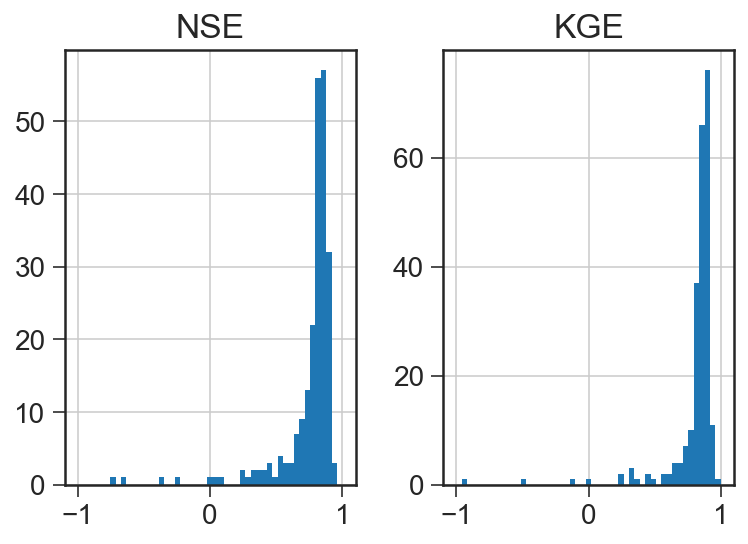

In [37]:
best_info_total[['NSE','KGE']].hist(bins = np.linspace(-1,1))

In [38]:
print('fraction (number) of sites with NSE>0.5: ',len(best_info_total[best_info_total.NSE>0.5])/len(best_info_total),
     len(best_info_total[best_info_total.NSE>0.5]))
print('fraction (number) of sites with KGE>0.3: ',len(best_info_total[best_info_total.KGE>0.3])/len(best_info_total),
     len(best_info_total[best_info_total.KGE>0.3]))
both = best_info_total[(best_info_total.NSE>0.5) & (best_info_total.KGE>0.3)]
print('fraction (number) of sites that meet both criteria: ',len(both)/len(best_info_total),len(both))

fraction (number) of sites with NSE>0.5:  0.8931623931623932 209
fraction (number) of sites with KGE>0.3:  0.9700854700854701 227
fraction (number) of sites that meet both criteria:  0.8931623931623932 209


In [40]:
temp_coeff_summer = [best_info_total['summer_params'].iloc[i][0] for i in range(len(best_info_total))]
flow_coeff_summer = [best_info_total['summer_params'].iloc[i][1] for i in range(len(best_info_total))]
intercept_summer = [best_info_total['summer_params'].iloc[i][2] for i in range(len(best_info_total))]

temp_coeff_winter = [best_info_total['winter_params'].iloc[i][0] for i in range(len(best_info_total))]
flow_coeff_winter = [best_info_total['winter_params'].iloc[i][1] for i in range(len(best_info_total))]
intercept_winter = [best_info_total['winter_params'].iloc[i][2] for i in range(len(best_info_total))]

temp_coeff_spring = [best_info_total['spring_params'].iloc[i][0] for i in range(len(best_info_total))]
flow_coeff_spring = [best_info_total['spring_params'].iloc[i][1] for i in range(len(best_info_total))]
intercept_spring = [best_info_total['spring_params'].iloc[i][2] for i in range(len(best_info_total))]

Text(0.5, 0, 'Intercept')

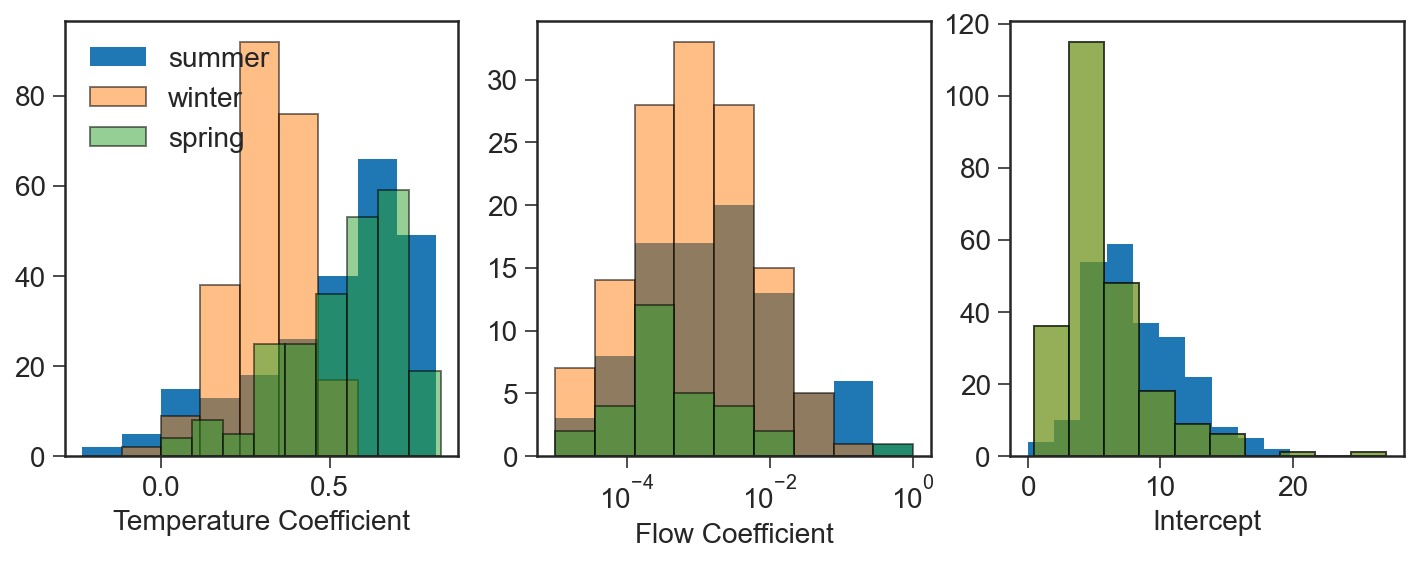

In [41]:

fig,ax = plt.subplots(1,3,figsize = (12,4))

ax0 = ax[0]
# ax0.set_xscale('log')
ax0.hist(temp_coeff_summer,bins = np.linspace(np.nanmin(temp_coeff_summer),
                                              np.nanmax(temp_coeff_summer),10),
        label = 'summer')
ax0.hist(temp_coeff_winter,bins = np.linspace(np.nanmin(temp_coeff_summer),
                                              np.nanmax(temp_coeff_summer),10),
        label = 'winter',alpha = 0.5,edgecolor = 'k')
ax0.hist(temp_coeff_spring,bins = np.linspace(np.nanmin(temp_coeff_spring),
                                              np.nanmax(temp_coeff_spring),10),
        label = 'spring',alpha = 0.5,edgecolor = 'k')
ax0.legend()
ax0.set_xlabel('Temperature Coefficient')

ax1 = ax[1]
ax1.hist(flow_coeff_summer,bins = np.logspace(-5,0,10),
        label = 'summer')
ax1.hist(flow_coeff_winter,bins = np.logspace(-5,0,10),
        label = 'winter',alpha = 0.5,edgecolor = 'k')
ax1.hist(flow_coeff_spring,bins = np.logspace(-5,0,10),
        label = 'spring',alpha = 0.5,edgecolor = 'k')
ax1.set_xscale('log')
ax1.set_xlabel('Flow Coefficient')

ax2 = ax[2]
ax2.hist(intercept_summer,label = 'summer')#,bins = np.linspace(-10,0,10))
ax2.hist(intercept_winter,label = 'winter',alpha = 0.5,edgecolor = 'k')
ax2.hist(intercept_winter,label = 'spring',alpha = 0.5,edgecolor = 'k')
# ax2.set_xscale('log')
ax2.set_xlabel('Intercept')
# ax2.legend()

In [31]:
state_outline = gpd.read_file('../Data/maps_and_boundaries/US_state_outline/cb_2018_us_state_500k.shp').to_crs(epsg=4326)
gagesII = gagesII.to_crs(epsg=4326)

In [42]:
best_info = best_info_total.merge(gagesII,left_on='sitenum',right_on='STAID',how='left')

Text(0, 0.5, 'KGE/NSE')

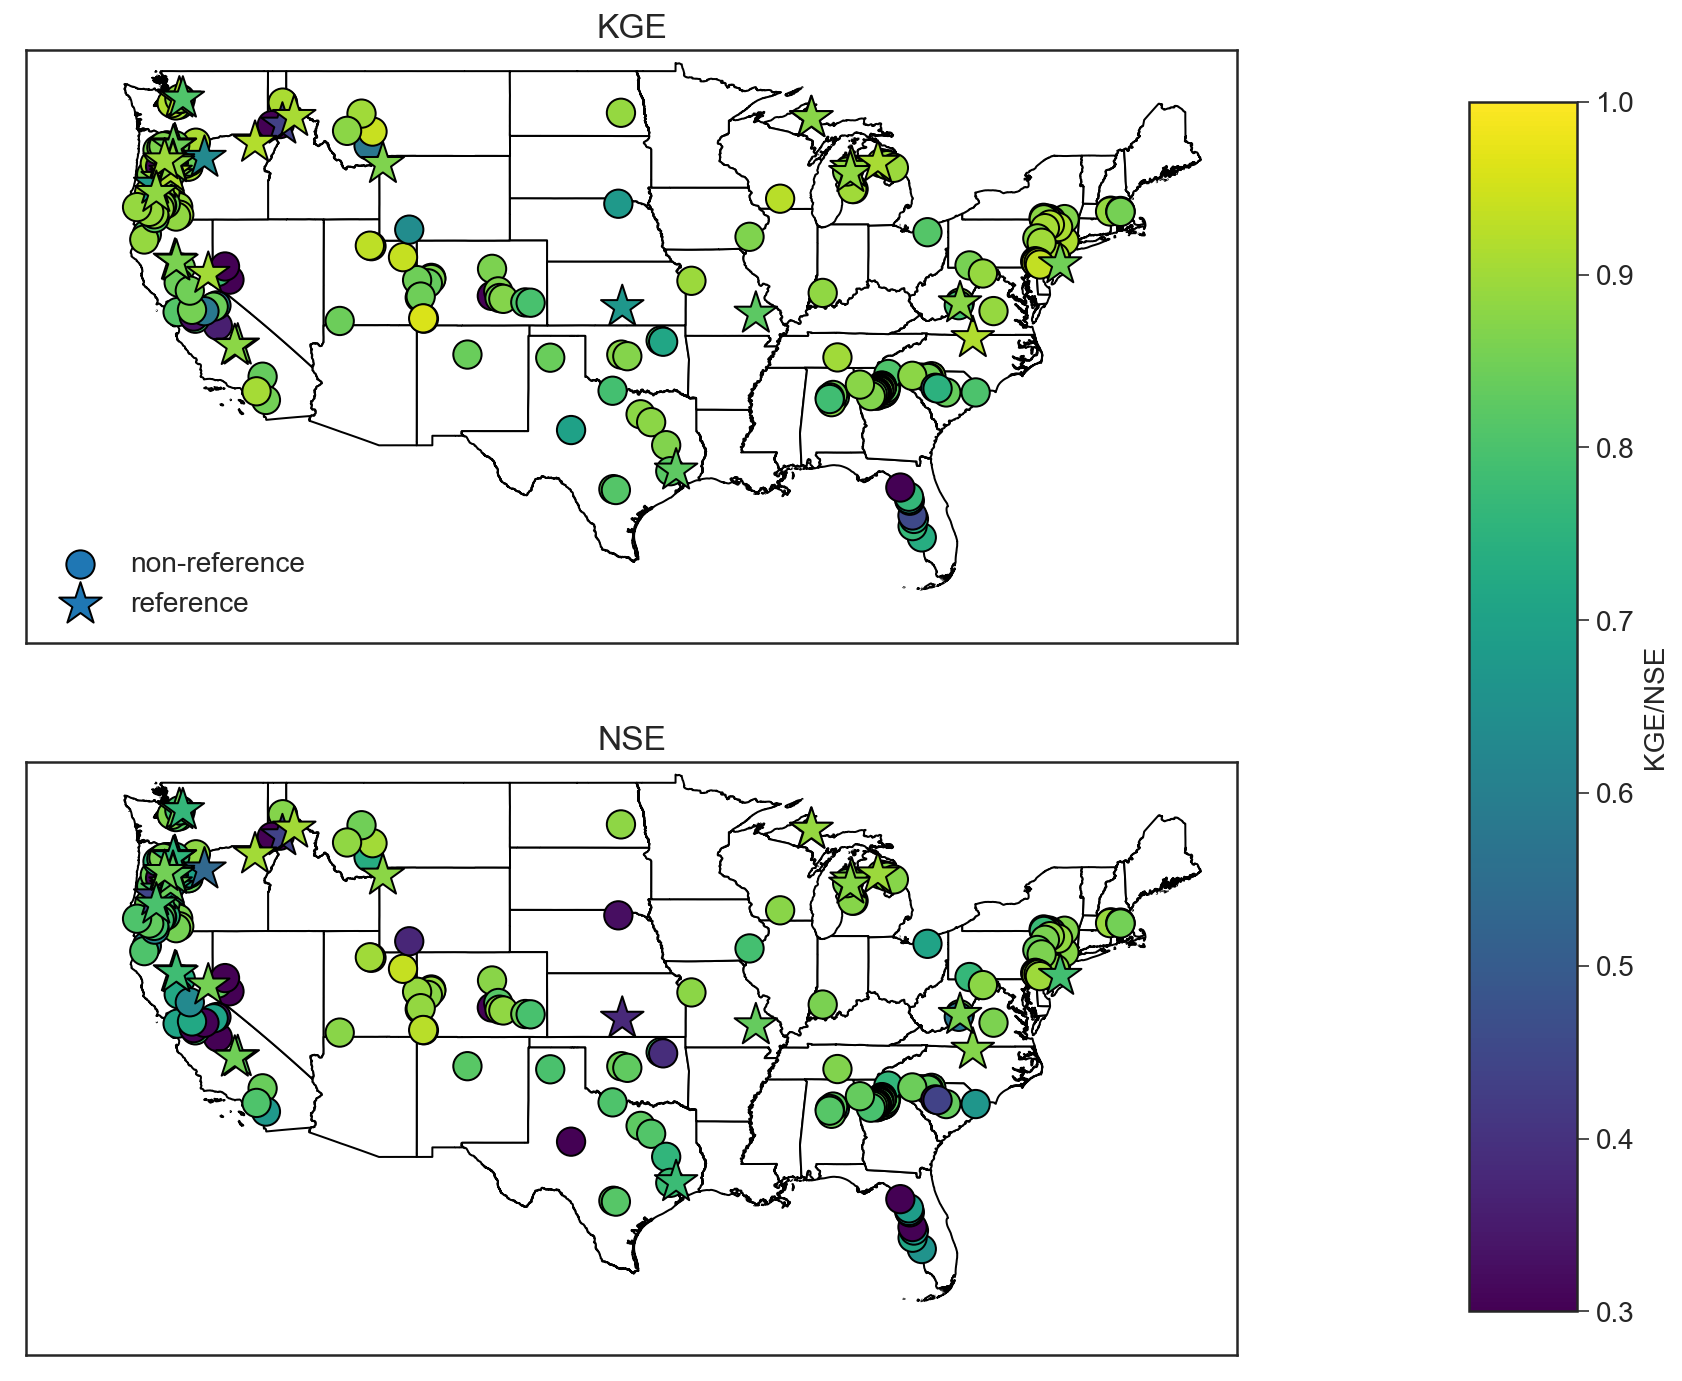

In [43]:
fig,ax = plt.subplots(2,figsize =(15,12))
for i in range(2):
    state_outline.plot(facecolor='white',edgecolors = 'k', ax=ax[i])
    ax[i].set_xlim(-130,-65)
    ax[i].set_ylim(22,50)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

cmap_use = 'viridis'#'magma'
best_info_ref = best_info[best_info.CLASS=='Ref']
best_info_nonref = best_info[best_info.CLASS=='Non-ref']
    
ax0=ax[0]
im = ax0.scatter(best_info_nonref.LNG_GAGE,best_info_nonref.LAT_GAGE, c=best_info_nonref.KGE,
           cmap = cmap_use,vmin = 0.3, vmax = 1, edgecolor = 'k', s=200, label = 'non-reference')
ax0.scatter(best_info_ref.LNG_GAGE,best_info_ref.LAT_GAGE, c=best_info_ref.KGE,
           cmap = cmap_use,vmin = 0.3, vmax = 1, edgecolor = 'k', s=500, label = 'reference',
                marker = '*')
ax0.set_title('KGE')

ax1=ax[1]
im = ax1.scatter(best_info_nonref.LNG_GAGE,best_info_nonref.LAT_GAGE, c=best_info_nonref.NSE,
           cmap = cmap_use,vmin = 0.3, vmax = 1, edgecolor = 'k', s=200, label = 'non-reference')
ax1.scatter(best_info_ref.LNG_GAGE,best_info_ref.LAT_GAGE, c=best_info_ref.NSE,
           cmap = cmap_use,vmin = 0.3, vmax = 1, edgecolor = 'k', s=500, label = 'reference',
                marker = '*')
ax1.set_title('NSE')


cols = ['KGE']
# fit_threshold=0
# for i in range(3):
#     allgoodref = best_info_ref[(best_info_ref.mean_KGE>fit_threshold) &
#                        (best_info_ref.max_KGE>fit_threshold) &
#                        (best_info_ref.min_KGE>fit_threshold)]
#     allgoodnoref = best_info_nonref[(best_info_nonref.mean_KGE>fit_threshold) &
#                        (best_info_nonref.max_KGE>fit_threshold) &
#                        (best_info_nonref.min_KGE>fit_threshold)]
#     ax[i].scatter(allgoodref.LNG_GAGE,allgoodref.LAT_GAGE, c = None, edgecolor = 'firebrick',
#                  s=500, lw = 2, marker = '*')
#     ax[i].scatter(allgoodnoref.LNG_GAGE,allgoodnoref.LAT_GAGE, edgecolor = 'firebrick',
#                  s=200, lw = 2, c = allgoodnoref[cols[i]], cmap = cmap_use,vmin = 0,vmax=1)

ax[0].legend(frameon=False, loc = 'lower left')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('KGE/NSE')

Text(0, 0.5, 'water temperature (C)')

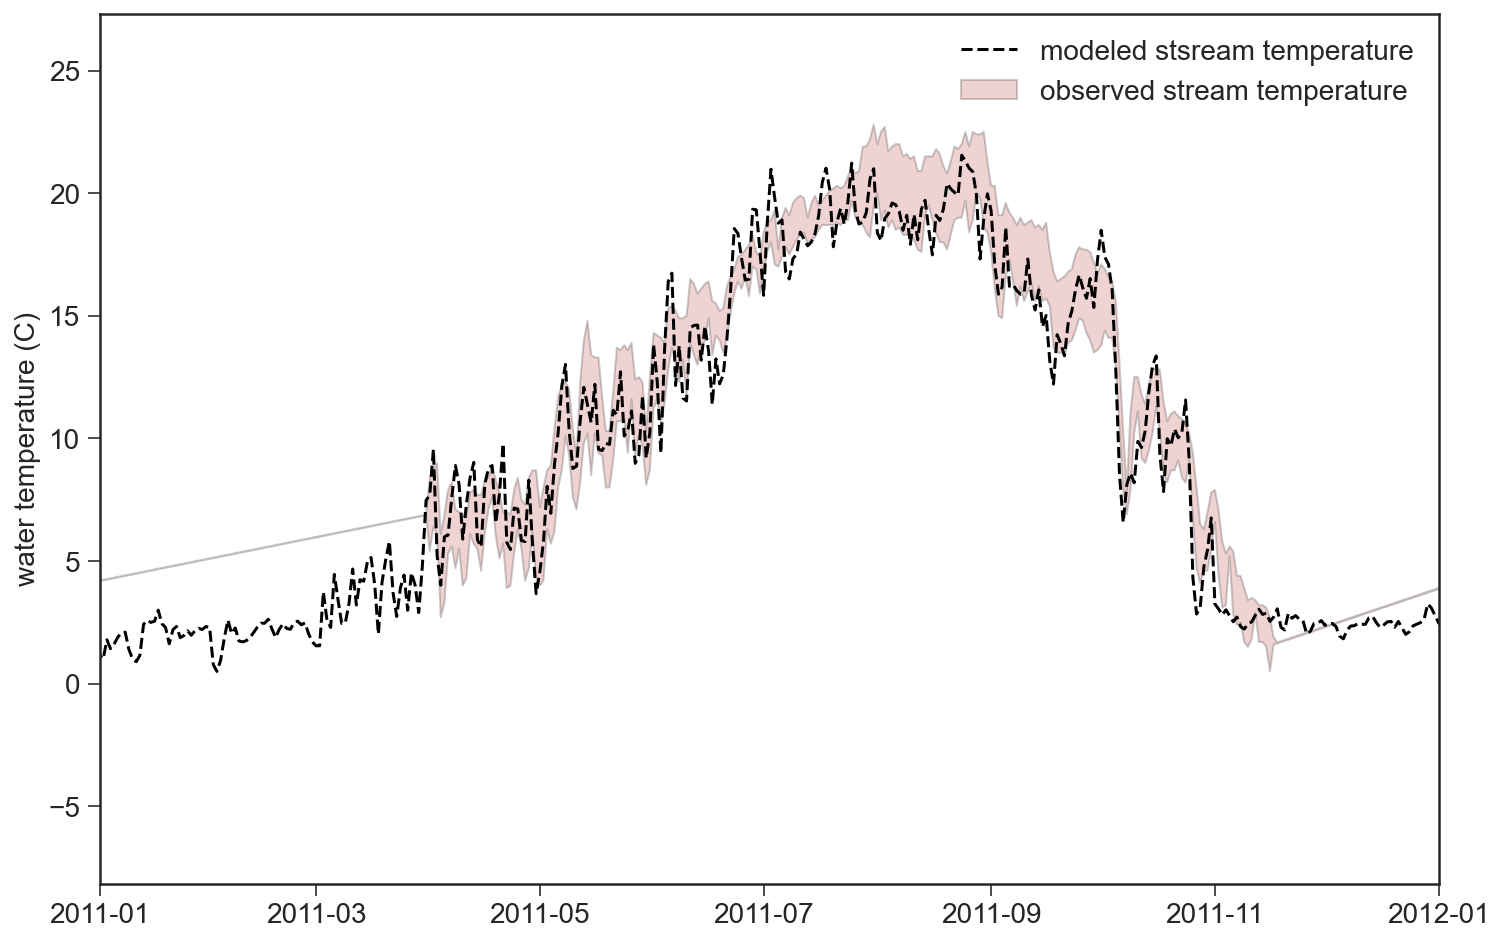

In [44]:
fig,ax = plt.subplots(1,figsize = (12,8))
ax.fill_between(state_data_day.index,state_data_day.Tmin_water,
               state_data_day.Tmax_water, edgecolor = 'k', 
                facecolor = 'firebrick',alpha = 0.2,
               label = 'observed stream temperature')
ax.plot(state_data_day.index,state_data_day.Tmean_modeled,
       c = 'k',ls = '--',label = 'modeled stsream temperature')
ax.legend(frameon=False)
# state_data_day[['Tmin_water','Tmax_water','Tmean_modeled']].plot(ax=ax)
plt.xlim(pd.to_datetime('1-1-2011'),pd.to_datetime('1-1-2012'))
plt.ylabel('water temperature (C)')

{'max_NSE': [0.7254292206199199],
 'min_NSE': [0.8866411064446731],
 'rollingonly_NSE': [-1.371809653646979],
 'max_KGE': [0.856807610598761],
 'min_KGE': [0.9163220247121794],
 'rollingonly_KGE': [0.48160294544740145],
 'best_BFI': [0.5663316582914574],
 'sitenum': ['11261500']}

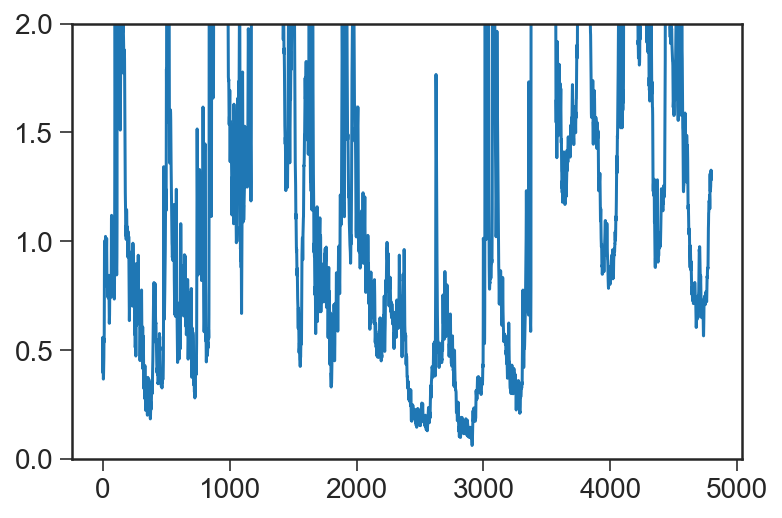

In [352]:
# best_info_total = best_info_total.reset_index().drop(columns='index')
rlen.reset_index()[rlen.reset_index().site==11261500]
# rlen.site.values
# save_best_i|nfo
plt.plot((state_data_day.discharge_cfs/np.nanmedian(state_data_day.discharge_cfs)).values)
plt.ylim(0,2)
save_best_info

In [190]:
# best_display = best_info_total[(best_info_total.best_BFI<0.5) & (best_info_total.mean_NSE>0.7)]
# best_display.merge(gagesII[['STAID','STANAME','LAT_GAGE','LNG_GAGE']],
#                   left_on='sitenum',right_on='STAID',how='left')

NameError: name 'guessmin' is not defined

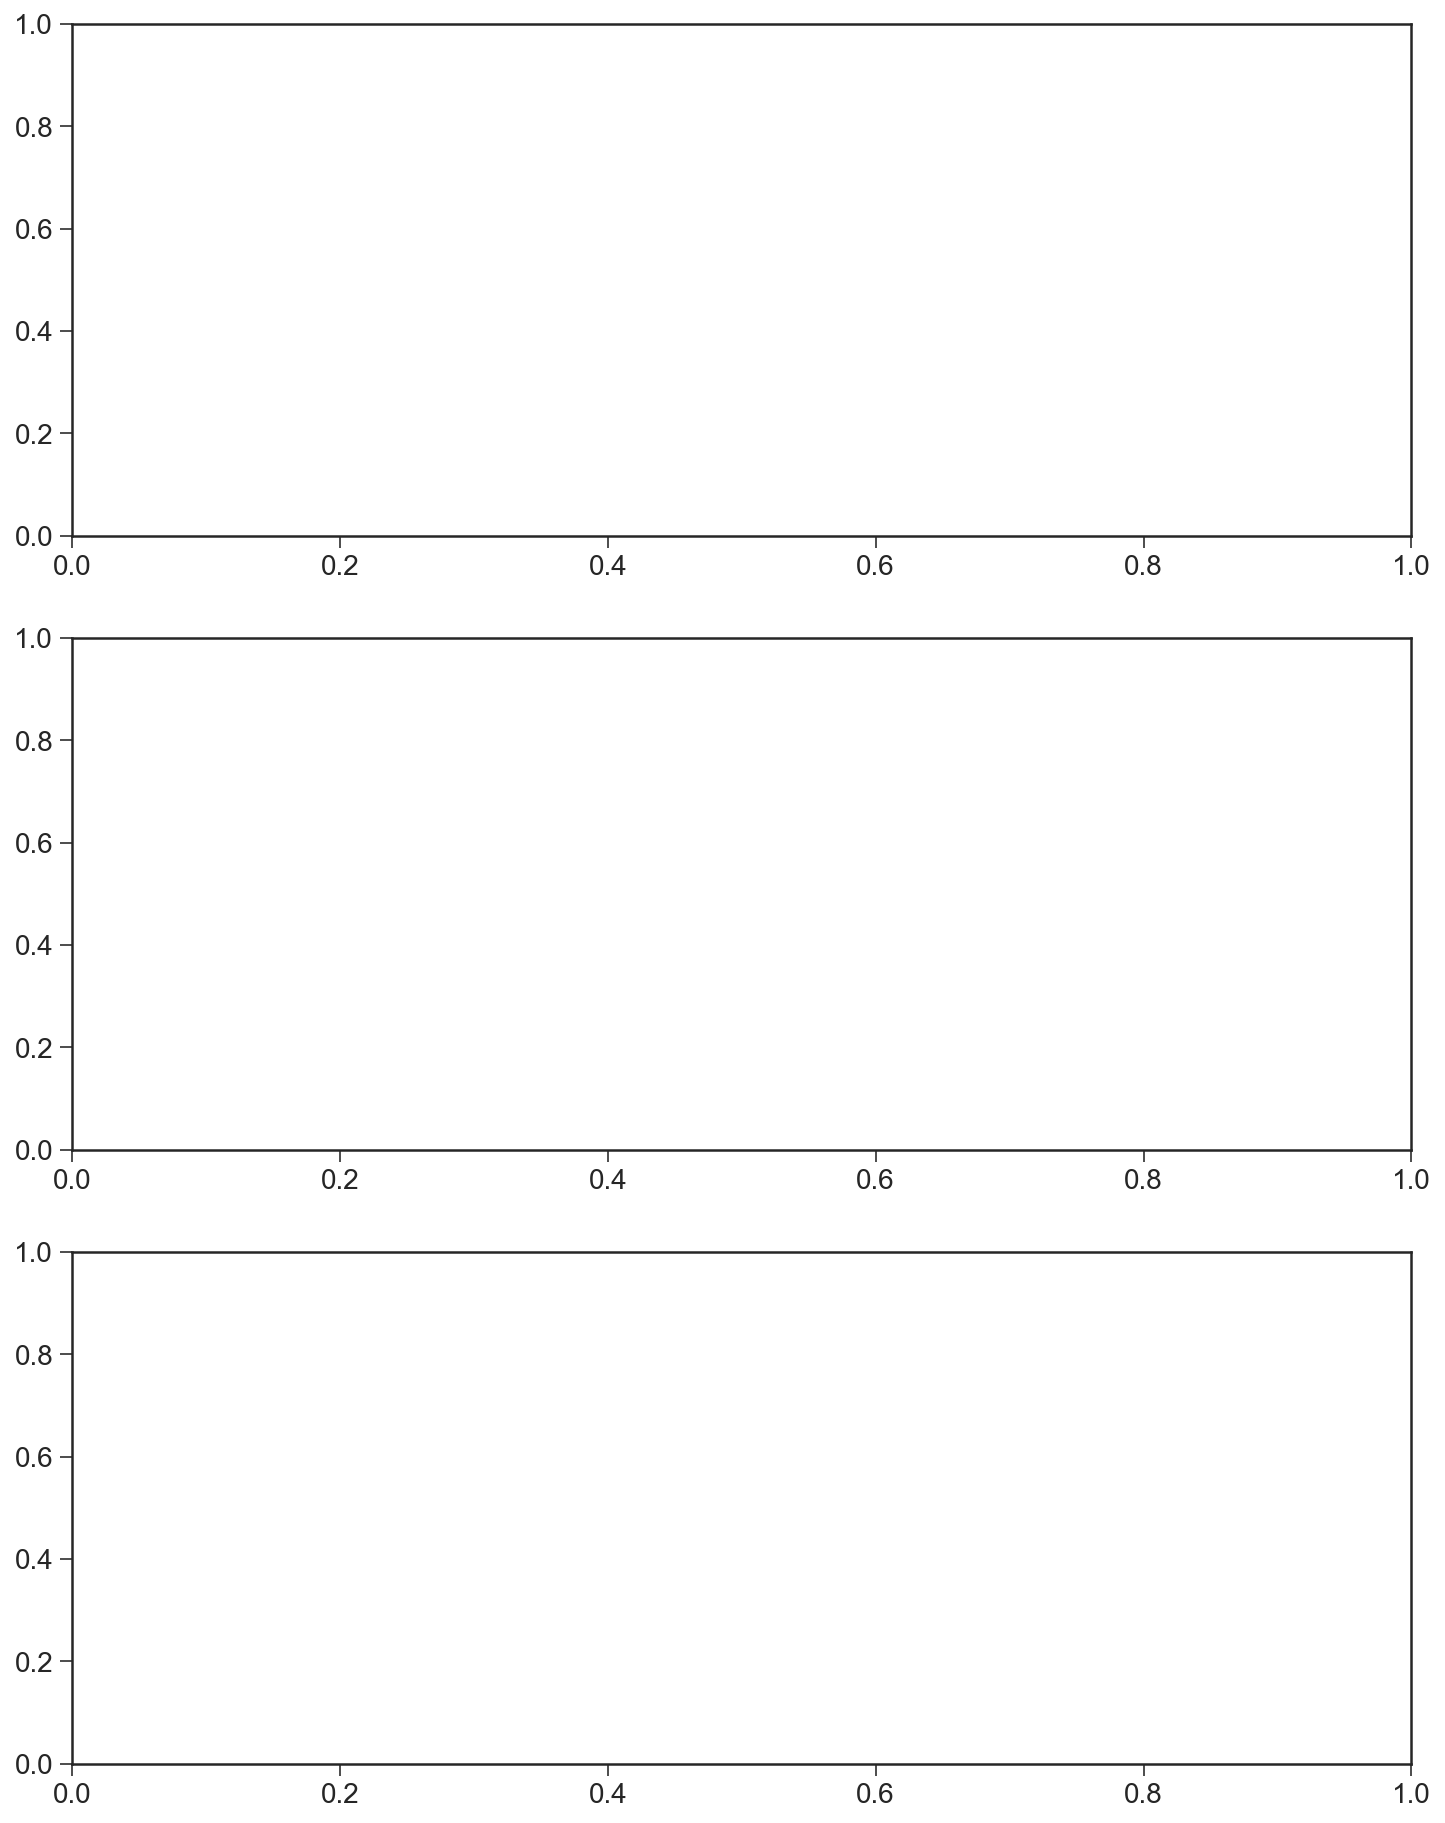

In [137]:
fig, ax = plt.subplots(3, figsize = (12,16))


ax0 = ax[0]
# state_data_day.discharge_cfs.plot(ax=ax0, label = None)
ax0.fill_between(state_data_day.index,0,state_data_day.E_bflow,
                label = 'baseflow',facecolor = 'teal',alpha = 0.2,
                edgecolor = 'k')
ax0.fill_between(state_data_day.index,state_data_day.E_bflow,
                state_data_day.discharge_cfs,label = 'flashflow',
                facecolor = 'bisque',alpha = 0.5,edgecolor = 'k')
ax0.set_yscale('symlog')
# ax0.axhline(maxfrac,c='k',ls='--')
# ax00=ax0.twinx()
# ax00.plot(state_data_day.index,fracs,c='darkorchid',
#           label='Fraction applied to initial stream temperature estimae')
# ax00.set_ylim(0,1.1)
# ax00.legend(loc='lower right',frameon=False)
# ax00.set_ylabel('Mixing fraction for initial stream temperature')

ax1 = ax[1]
ax1.fill_between(state_data_day.index,
                state_data_day[['tmin','tmean']].mean(axis=1),
                state_data_day[['tmax','tmean']].mean(axis=1),
                facecolor='skyblue',alpha=0.2)
ax1.axhline(groundwater_temp,c='k',lw=2,ls='--',label='Groundwater temperature end-member')
# groundwater_temp.plot(ax=ax1, c='k',lw=2, ls='--',
#                                               label = 'Groundwater temperature end-member',)
mintemp.plot(ax=ax1, c='steelblue', label = 'Minimum surface water temperature end-member', )
# meantemp.plot(ax=ax1, c='goldenrod',label = 'Mean surface water temperature end-member', )
maxtemp.plot(ax=ax1, c='firebrick',label = 'Maximum surface water temperature end-member', )



ax3 = ax[2]
ax3.fill_between(guessmin.index,guessmin,guessmax,facecolor = 'skyblue',alpha=0.2)
guessmin.plot(ax=ax3,c='steelblue',label = 'Minimum modeled stream temperature')
# guessmean.plot(ax=ax3,c='goldenrod',label = 'Mean modeled stream temperature')
guessmax.plot(ax=ax3,c='firebrick',label = 'Maximum modeled stream temperature')
# state_data.temperature_C.plot(ax=ax3, label = 'Observed stream temperature', c='k')
ax3.fill_between(state_data_day.index,state_data_day.Tmin_water,state_data_day.Tmax_water,
                facecolor='k',alpha=0.2,label = 'Observed stream temperature')




for i in range(3):
    ax[i].set_xlim(pd.to_datetime('1-1-2012'),pd.to_datetime('1-1-2014'))
    if i==0:
        ax[i].set_ylabel('Streamflow (ft$^3$/s)')
        ax[i].set_ylim(0,3000)
    else:
        ax[i].set_ylim(-30,45)
        ax[i].set_ylabel('Temperature ($^{\circ}$C)')
    ax[i].legend(loc = 'lower left',frameon=False)
    if i==2:
        ax[i].set_xlabel('')
    else:
        ax[i].set_xticks([])
        ax[i].set_xlabel('')
        
letterplace = pd.to_datetime('1-5-2012')
ax0.text(letterplace,4000,'a)')
ax1.text(letterplace,48,'b)')
ax3.text(letterplace,48,'c)')

ax3.text(letterplace,35,
         'min. stream temperature NSE = {:0.2f}'.format(best_info_total.min_NSE.values[-1])+
        '\nmax. stream temperature NSE = {:0.2f}'.format(best_info_total.max_NSE.values[-1]))
ax0.text(letterplace,1500,
         'BFI_max = {:0.2f}'.format(best_info_total.best_BFI.values[-1]))

plt.savefig('../figures/endmember_mixing_overview.pdf', format='pdf',bbox_inches = "tight")

In [350]:
50*3600

180000

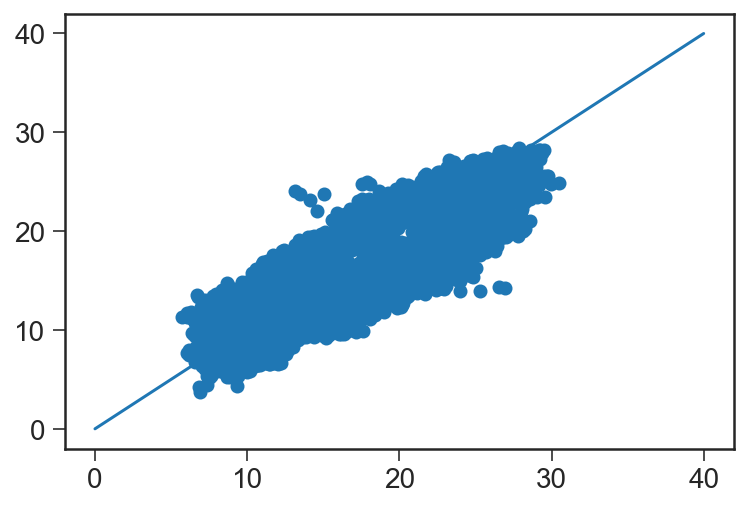

In [274]:
# plt.scatter(state_data.temperature_C.resample('D').mean().values,guessmean)
mean_plot = state_data.temperature_C.resample('D').mean().to_frame().tz_convert(None).merge(guessmean.to_frame(),left_index=True,
                                                                          right_index=True)
plt.scatter(mean_plot.temperature_C,mean_plot[0])
plt.plot([0,40],[0,40])

In [358]:
best_info_total = pd.read_csv('../Data/end_member_model_performance1.csv')
# best_info_total['sitenum'] = best_info_total.sitenum.astype('str')
# str_lengths = np.array([len(best_info_total.sitenum.values[i]) for i in range(len(best_info_total))])

# best_info_total['sitenum'] = np.where(str_lengths<8,
#                                       '0'+best_info_total.sitenum,
#                                       best_info_total.sitenum)

In [360]:
best_info_improve = best_info_total[(best_info_total.min_NSE>best_info_total.rollingonly_NSE) &
               (best_info_total.min_KGE>best_info_total.rollingonly_KGE)]
best_info_improve = best_info_improve[#(best_info_improve.mean_NSE>0.5) &
                                     (best_info_improve.min_NSE>0.5) &
                                     (best_info_improve.max_NSE>0.5)]
best_info_improve = best_info_improve[#(best_info_improve.mean_KGE>0.3) &
                                     (best_info_improve.min_KGE>0.3) &
                                     (best_info_improve.max_KGE>0.3)]
best_info_improve = best_info_improve.merge(gagesII[['STAID','STANAME','LAT_GAGE','LNG_GAGE','CLASS']],
                                           left_on='sitenum',right_on='STAID',how='left')
best_info_improve.to_csv('../Data/end_member_performance_behavioral.csv',index=False)

In [361]:
len(best_info_improve)

134

In [362]:
best_info_total = pd.read_csv('../Data/end_member_performance_behavioral.csv')

(0.0, 80.0)

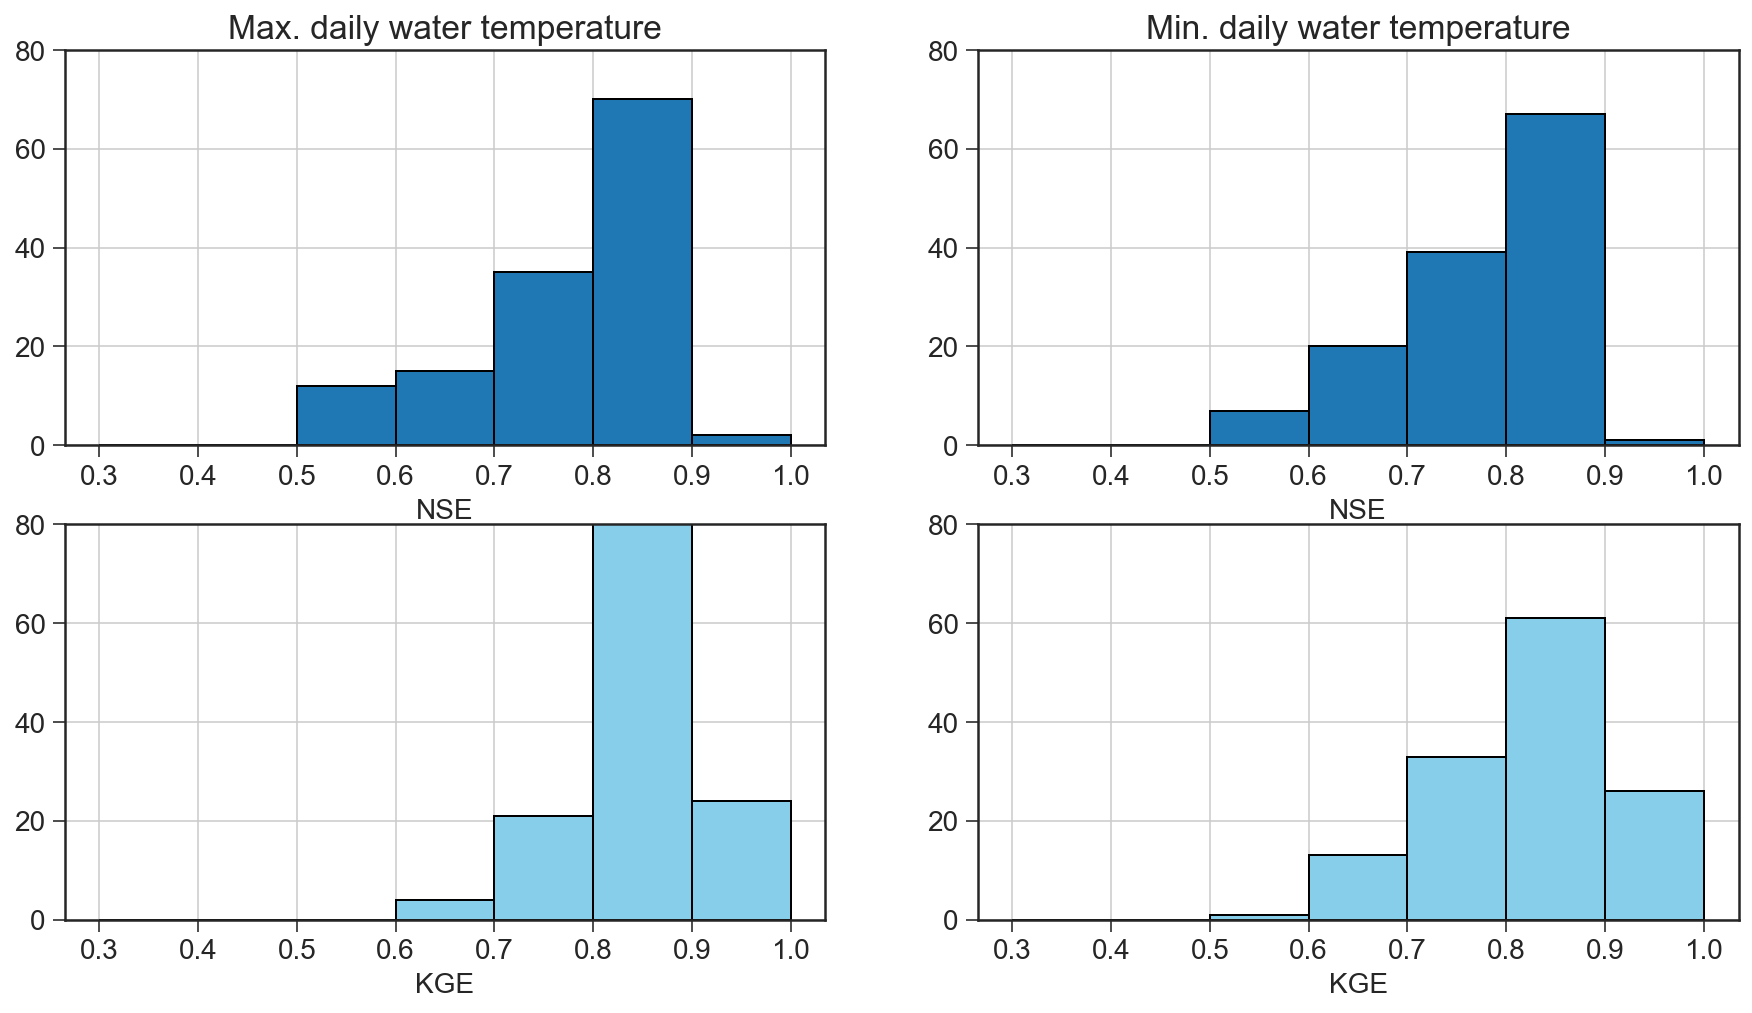

In [365]:
fig, ax = plt.subplots(2,2,figsize = (15,8))

# ax0 = ax[0][0]
# best_info_total.mean_NSE.hist(edgecolor='k',bins = np.linspace(0.3,1,8),ax = ax0)
# ax0.set_title('Mean daily water temperature')
# ax0.set_ylabel('Number of stations')
# ax0.set_xlabel('NSE')
# ax0.set_ylim(0,80)

# ax1 = ax[1][0]
# best_info_total.mean_KGE.hist(edgecolor = 'k',bins = np.linspace(0.3,1,8),ax=ax1,facecolor='skyblue')
# ax1.set_ylabel('Number of stations')
# ax1.set_xlabel('KGE')
# ax1.set_ylim(0,80)

ax0 = ax[0][0]
best_info_total.max_NSE.hist(edgecolor='k',bins = np.linspace(0.3,1,8),ax = ax0)
ax0.set_title('Max. daily water temperature')
# ax0.set_ylabel('Number of stations')
ax0.set_xlabel('NSE')
ax0.set_ylim(0,80)

ax1 = ax[1][0]
best_info_total.max_KGE.hist(edgecolor = 'k',bins = np.linspace(0.3,1,8),ax=ax1,facecolor='skyblue')
# ax1.set_ylabel('Number of stations')
ax1.set_xlabel('KGE')
ax1.set_ylim(0,80)

ax0 = ax[0][1]
best_info_total.min_NSE.hist(edgecolor='k',bins = np.linspace(0.3,1,8),ax = ax0)
ax0.set_title('Min. daily water temperature')
# ax0.set_ylabel('Number of stations')
ax0.set_xlabel('NSE')
ax0.set_ylim(0,80)

ax1 = ax[1][1]
best_info_total.min_KGE.hist(edgecolor = 'k',bins = np.linspace(0.3,1,8),ax=ax1,facecolor='skyblue')
# ax1.set_ylabel('Number of stations')
ax1.set_xlabel('KGE')
ax1.set_ylim(0,80)

In [366]:
# best_info_total['sitenum'] = best_info_total.sitenum.astype('str')
# best_info_total['sitenum'] = np.where(len(best_info_total.sitenum)<8,
#                                       '0'*(8-len(best_info_total.sitenum))+best_info_total.sitenum,
#                                       best_info_total.sitenum)
# best_info = best_info_total.merge(gagesII[['STAID','geometry','CLASS']],
#                                   left_on='sitenum',
#                                  right_on='STAID',how='left')
best_info = best_info_total#gpd.GeoDataFrame(best_info, geometry = best_info.geometry)
state_outline = gpd.read_file('../Data/maps_and_boundaries/US_state_outline/cb_2018_us_state_500k.shp').to_crs(epsg=4326)
gagesII = gagesII.to_crs(epsg=4326)

Text(0, 0.5, 'KGE')

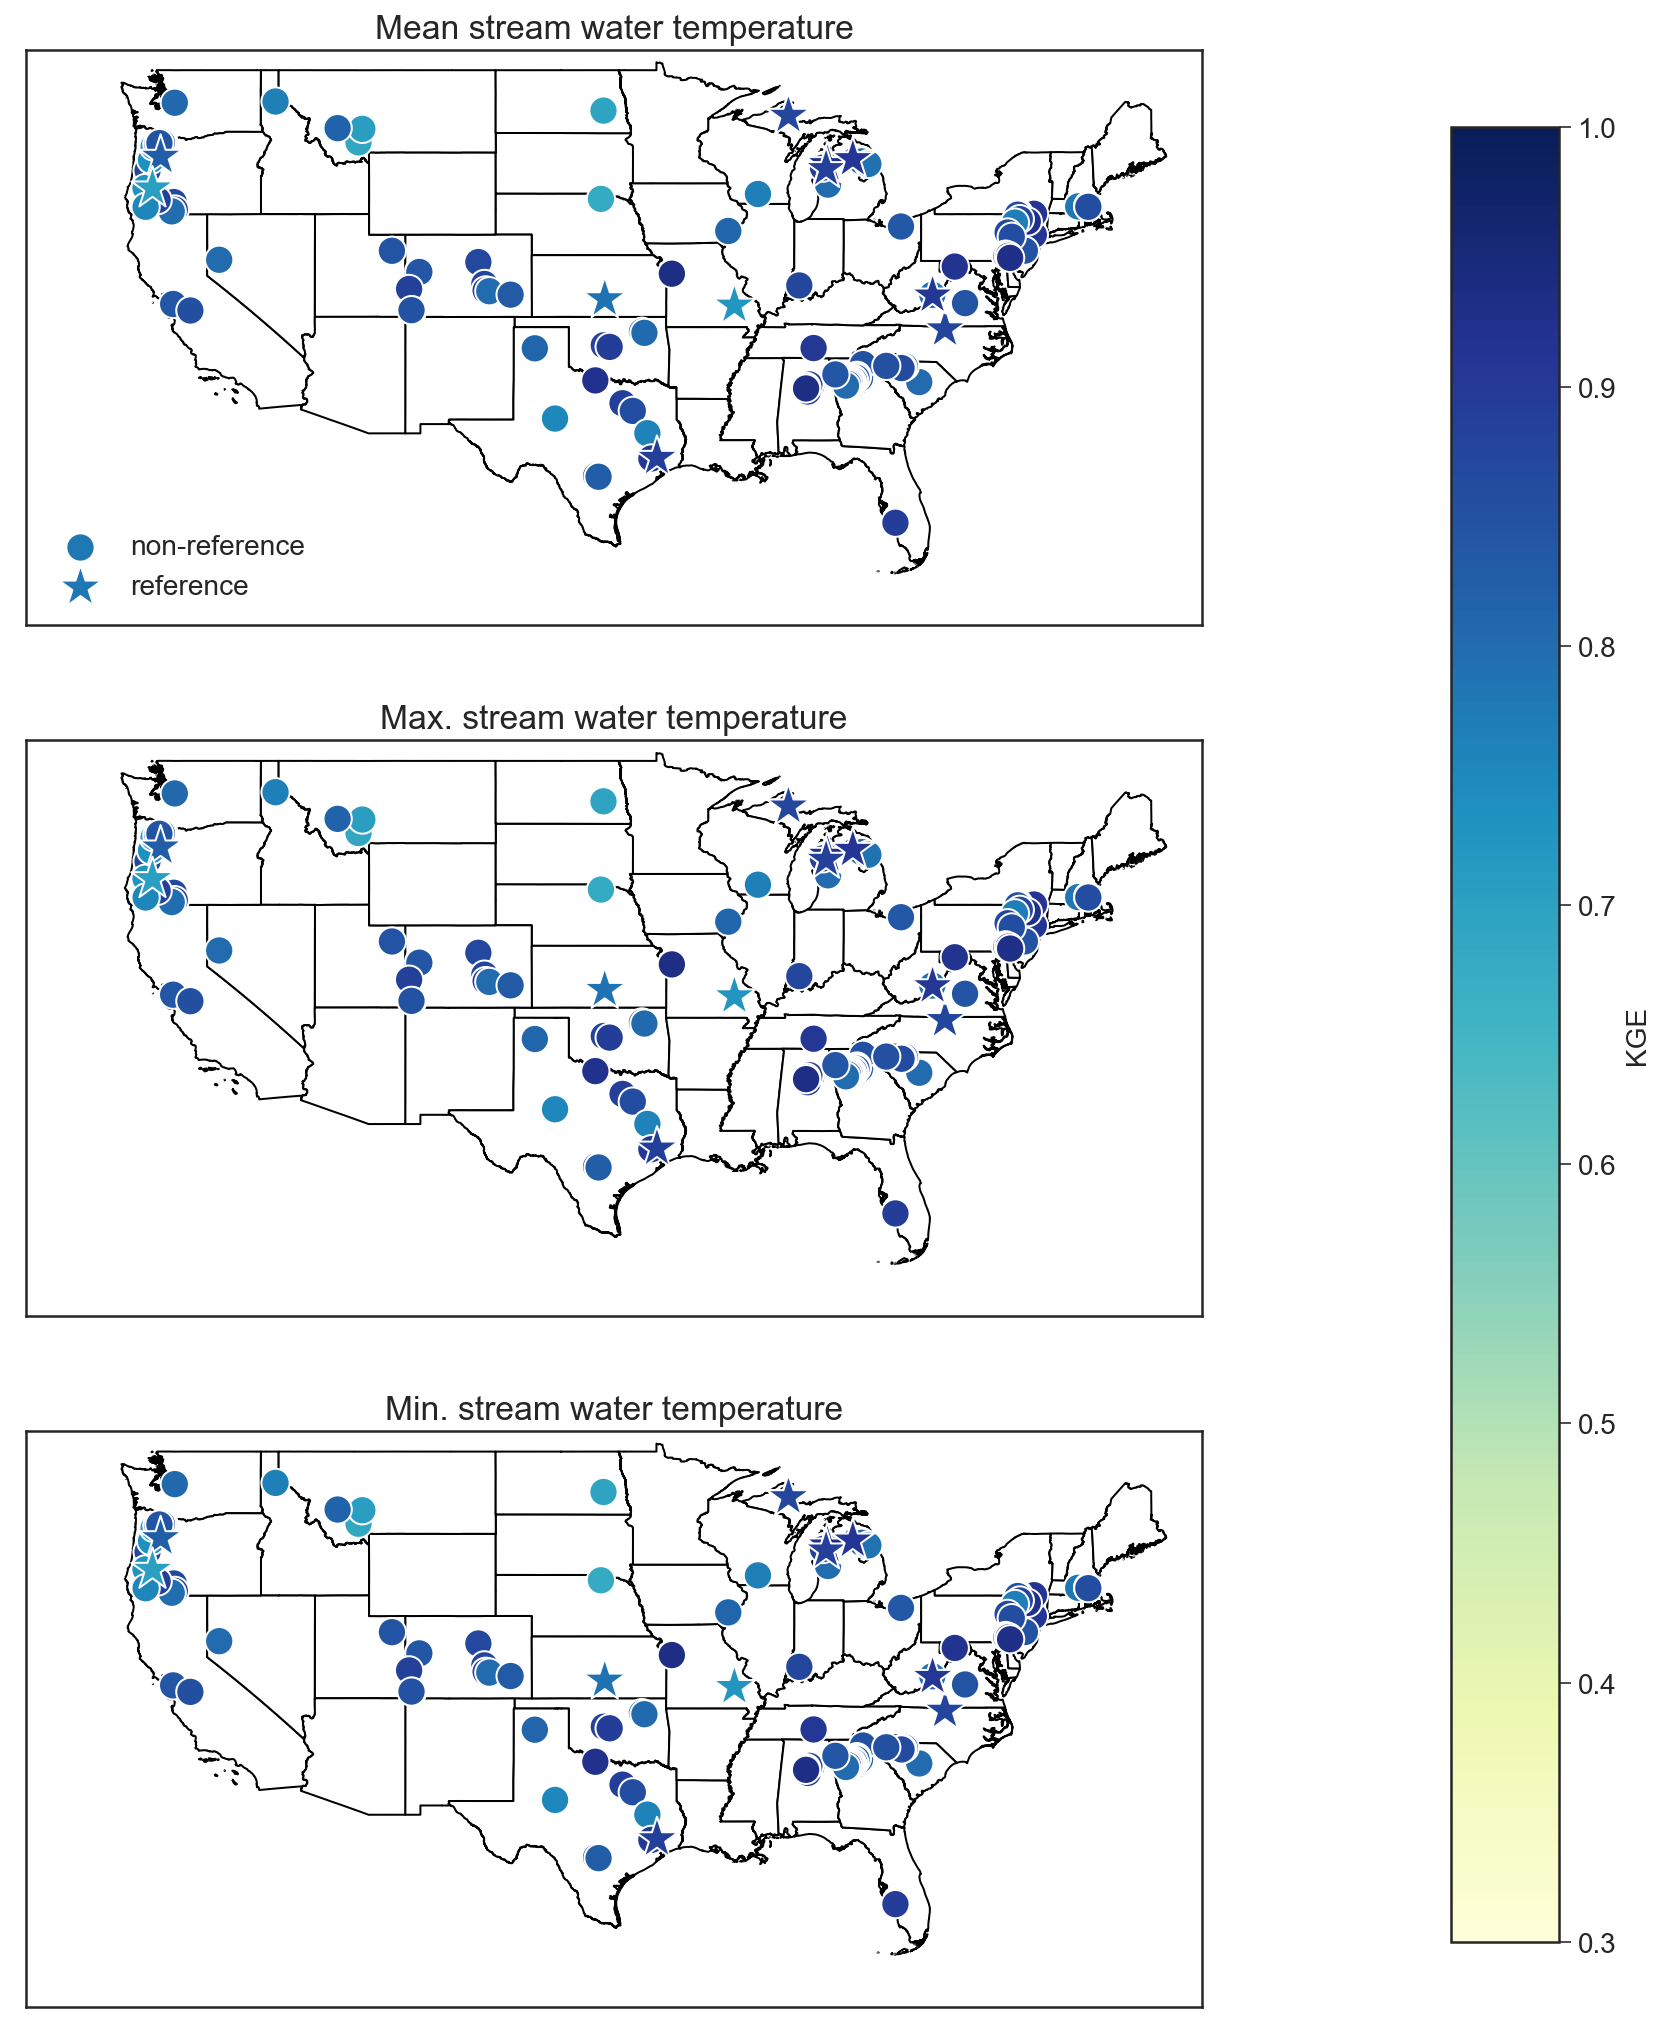

In [369]:
fig,ax = plt.subplots(3,figsize =(15,18))
for i in range(3):
    state_outline.plot(facecolor='white',edgecolors = 'k', ax=ax[i])
    ax[i].set_xlim(-130,-65)
    ax[i].set_ylim(22,50)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

cmap_use = 'YlGnBu'#'magma'
best_info_ref = best_info[best_info.CLASS=='Ref']
best_info_nonref = best_info[best_info.CLASS=='Non-ref']
    
ax0=ax[0]
im = ax0.scatter(best_info_nonref.LNG_GAGE,best_info_nonref.LAT_GAGE, c=best_info_nonref.max_KGE,
           cmap = cmap_use,vmin = 0.3, vmax = 1, edgecolor = 'white', s=200, label = 'non-reference')
ax0.scatter(best_info_ref.LNG_GAGE,best_info_ref.LAT_GAGE, c=best_info_ref.max_KGE,
           cmap = cmap_use,vmin = 0.3, vmax = 1, edgecolor = 'white', s=500, label = 'reference',
                marker = '*')
ax0.set_title('Mean stream water temperature')

ax0 = ax[1]
ax0.scatter(best_info_nonref.LNG_GAGE,best_info_nonref.LAT_GAGE, c=best_info_nonref.max_KGE,
           cmap = cmap_use,vmin = 0.3, vmax = 1, edgecolor = 'white', s=200, label = 'non-reference')
ax0.scatter(best_info_ref.LNG_GAGE,best_info_ref.LAT_GAGE, c=best_info_ref.max_KGE,
           cmap = cmap_use,vmin = 0.3, vmax = 1, edgecolor = 'white', s=500, label = 'reference',
                marker = '*')
ax0.set_title('Max. stream water temperature')

ax0 = ax[2]
ax0.scatter(best_info_nonref.LNG_GAGE,best_info_nonref.LAT_GAGE, c=best_info_nonref.max_KGE,
           cmap = cmap_use,vmin = 0.3, vmax = 1, edgecolor = 'white', s=200, label = 'non-reference')
ax0.scatter(best_info_ref.LNG_GAGE,best_info_ref.LAT_GAGE, c=best_info_ref.max_KGE,
           cmap = cmap_use,vmin = 0.3, vmax = 1, edgecolor = 'white', s=500, label = 'reference',
                marker = '*')
ax0.set_title('Min. stream water temperature')

cols = ['mean_KGE','max_KGE','min_KGE']
# fit_threshold=0
# for i in range(3):
#     allgoodref = best_info_ref[(best_info_ref.mean_KGE>fit_threshold) &
#                        (best_info_ref.max_KGE>fit_threshold) &
#                        (best_info_ref.min_KGE>fit_threshold)]
#     allgoodnoref = best_info_nonref[(best_info_nonref.mean_KGE>fit_threshold) &
#                        (best_info_nonref.max_KGE>fit_threshold) &
#                        (best_info_nonref.min_KGE>fit_threshold)]
#     ax[i].scatter(allgoodref.LNG_GAGE,allgoodref.LAT_GAGE, c = None, edgecolor = 'firebrick',
#                  s=500, lw = 2, marker = '*')
#     ax[i].scatter(allgoodnoref.LNG_GAGE,allgoodnoref.LAT_GAGE, edgecolor = 'firebrick',
#                  s=200, lw = 2, c = allgoodnoref[cols[i]], cmap = cmap_use,vmin = 0,vmax=1)

ax[0].legend(frameon=False, loc = 'lower left')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('KGE')

In [372]:
fit_threshold = 0.3
print('total number of sites:',len(best_info))
# print('number of sites with mean temp KGE>0.3:',len(best_info[best_info.mean_KGE>fit_threshold]))
print('number of sites all KGE>0.6:',len(best_info[#(best_info.mean_KGE>fit_threshold) &
                                                  (best_info.max_KGE>fit_threshold) &
                                                  (best_info.min_KGE>fit_threshold)]))
print('number of reference sites:',len(best_info_ref))
print('number of reference sites with all KGE>0.3:',len(best_info_ref[#(best_info_ref.mean_KGE>fit_threshold) &
                                                  (best_info_ref.max_KGE>fit_threshold) &
                                                  (best_info_ref.min_KGE>fit_threshold)]))

total number of sites: 134
number of sites all KGE>0.6: 134
number of reference sites: 12
number of reference sites with all KGE>0.3: 12


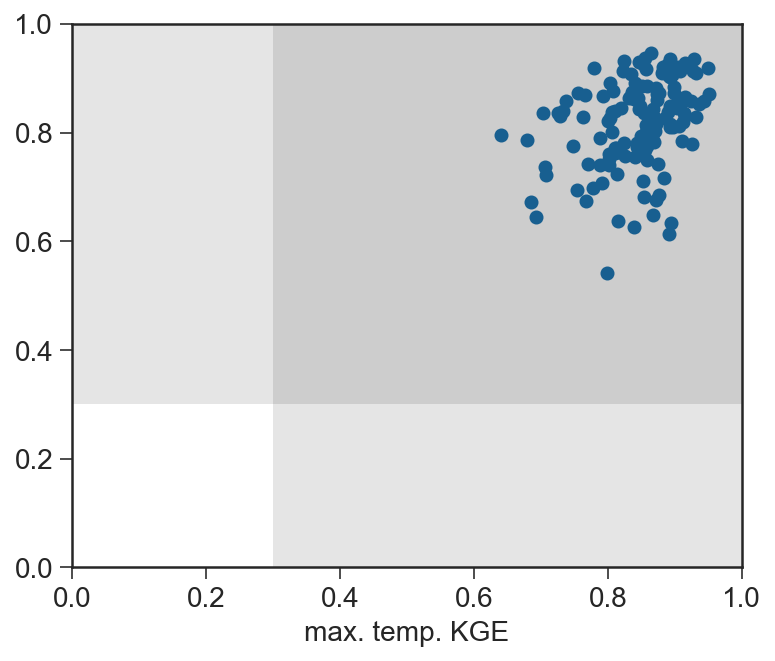

In [374]:
fig, ax = plt.subplots(1,1,figsize = (6,5))

ax0 = ax
ax0.axvspan(0.3,1,facecolor = 'k',alpha = 0.1)
ax0.axhspan(0.3,1,facecolor = 'k',alpha = 0.1)
ax0.scatter(best_info.max_KGE,best_info.min_KGE)

# ax1 = ax[1]
# ax1.axvspan(0.3,1,facecolor = 'k',alpha = 0.1)
# ax1.axhspan(0.3,1,facecolor = 'k',alpha = 0.1)
# ax1.scatter(best_info.min_KGE,best_info.mean_KGE)

# ax0.set_ylabel('mean temp. KGE')
ax0.set_xlabel('max. temp. KGE')
# ax1.set_xlabel('min. temp. KGE')

for i in range(1):
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

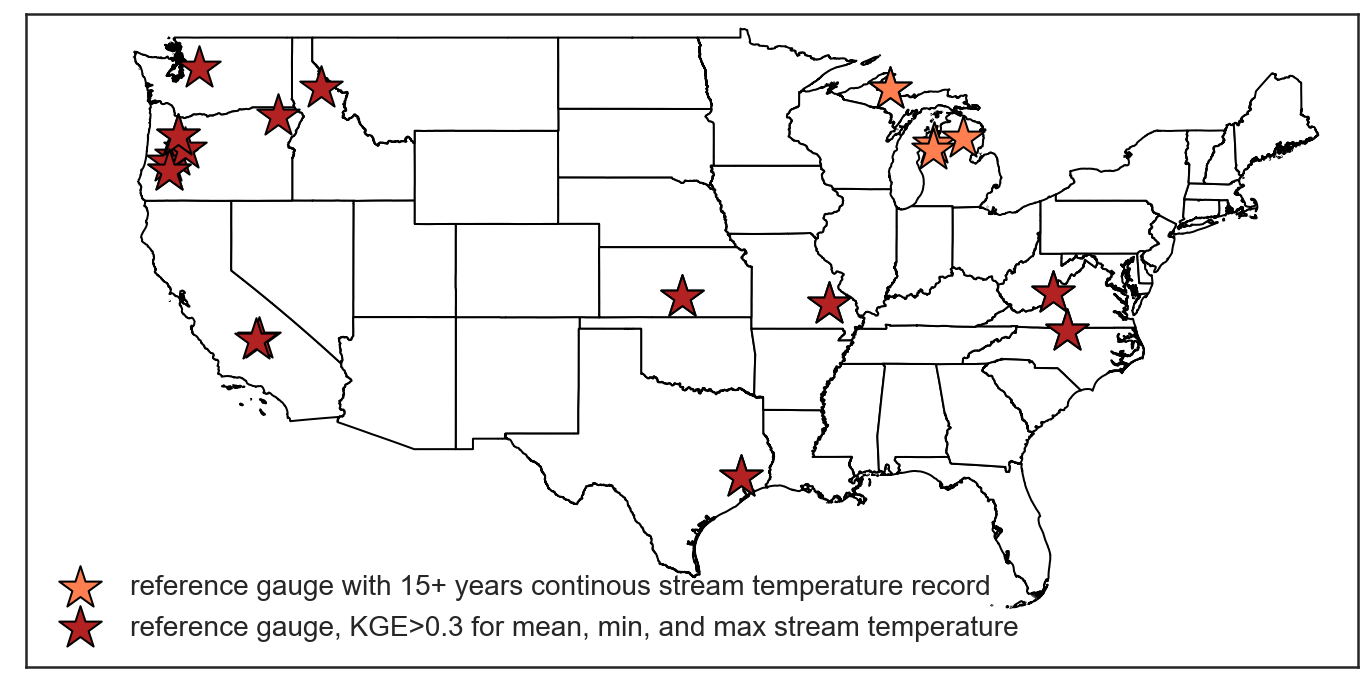

In [375]:
fig, ax = plt.subplots(1,figsize = (12,6))

state_outline.plot(facecolor='white',edgecolors = 'k', ax=ax)
ax.set_xlim(-130,-65)
ax.set_ylim(22,50)
ax.set_xticks([])
ax.set_yticks([])

ax.scatter(best_info_ref.LNG_GAGE,
          best_info_ref.LAT_GAGE, s=500, c = 'coral',marker = '*',
          edgecolor = 'k', label ='reference gauge with {:1.0f}+ years continous stream temperature record'.format(limit))

ax.scatter(allgoodref[allgoodref.CLASS=='Ref'].LNG_GAGE,
          allgoodref[allgoodref.CLASS=='Ref'].LAT_GAGE, s=500, c = 'firebrick',marker = '*',
          edgecolor = 'k', label = 'reference gauge, KGE>{:1.1f} for mean, min, and max stream temperature'.format(fit_threshold))

ax.legend(frameon=False,loc='lower left')

Text(0, 0.5, 'BFI')

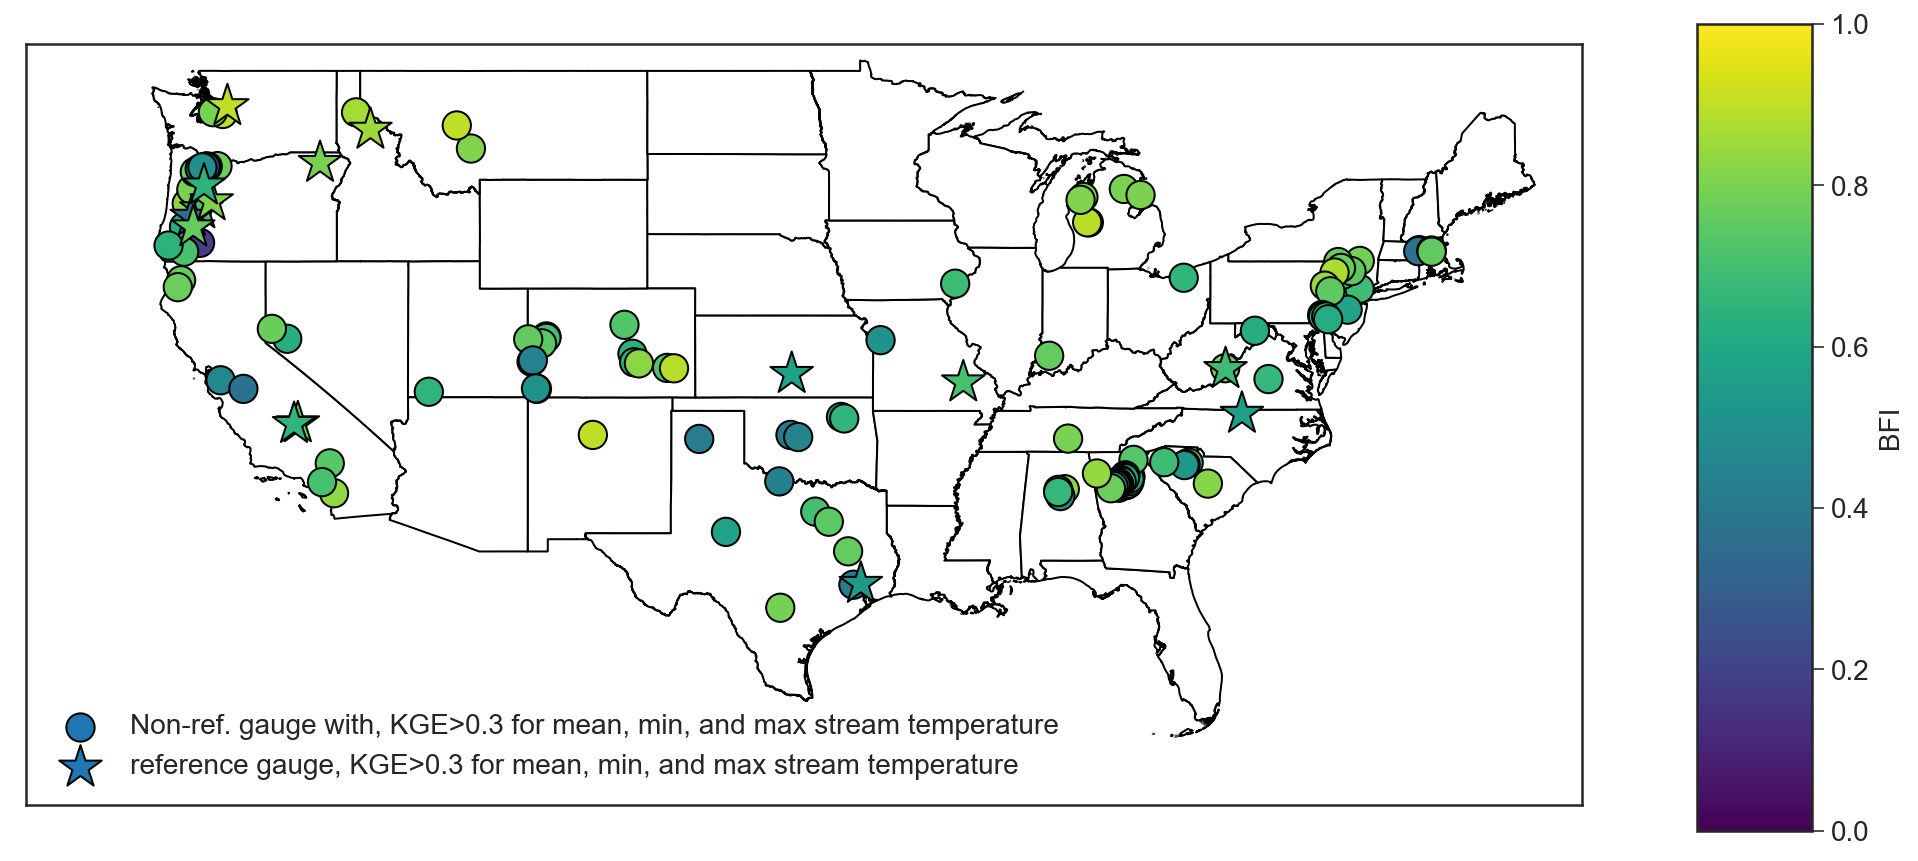

In [376]:
fig, ax = plt.subplots(1,figsize = (16,8))
cmap_use1 = 'viridis'

state_outline.plot(facecolor='white',edgecolors = 'k', ax=ax)
ax.set_xlim(-130,-65)
ax.set_ylim(22,50)
ax.set_xticks([])
ax.set_yticks([])


# ax.scatter(best_info_nonref.LNG_GAGE, best_info_nonref.LAT_GAGE, s=200, c=best_info_nonref.best_BFI, 
#           vmin = 0., vmax = 1, cmap = cmap_use1, edgecolor = 'k', 
#            label = 'Non-ref. gauge with {:1.0f}+ years continuous stream temperature record'.format(limit))

cm = ax.scatter(allgoodnoref.LNG_GAGE, allgoodnoref.LAT_GAGE, s=200, c=allgoodnoref.best_BFI, 
          vmin = 0., vmax = 1, cmap = cmap_use1, edgecolor = 'k',#edgecolor = 'firebrick',lw = 2, 
           label = 'Non-ref. gauge with, KGE>{:1.1f} for mean, min, and max stream temperature'.format(fit_threshold))

# cm = ax.scatter(best_info_ref.LNG_GAGE,
#           best_info_ref.LAT_GAGE, s=500, c = best_info_ref.best_BFI,marker = '*',vmin = 0., vmax = 1,cmap = cmap_use1,
#           edgecolor = 'k', label ='reference gauge with {:1.0f}+ years continous stream temperature record'.format(limit))

ax.scatter(allgoodref[allgoodref.CLASS=='Ref'].LNG_GAGE,
          allgoodref[allgoodref.CLASS=='Ref'].LAT_GAGE, s=500, c = allgoodref.best_BFI,
           vmin = 0., vmax = 1, cmap = cmap_use1, marker = '*',edgecolor = 'k',
#           edgecolor = 'firebrick', lw=2, 
           label = 'reference gauge, KGE>{:1.1f} for mean, min, and max stream temperature'.format(fit_threshold))


ax.legend(frameon=False,loc='lower left')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cm, cax=cbar_ax)
cbar.ax.set_ylabel('BFI')

In [377]:
gagesII['STAID'] = gagesII['STAID'].astype('int')
plot_stations = record_length.merge(gagesII[['STAID','geometry','CLASS','LNG_GAGE','LAT_GAGE']],
                   left_on='site',right_on='STAID',how='left').dropna()
plot_stations = best_info

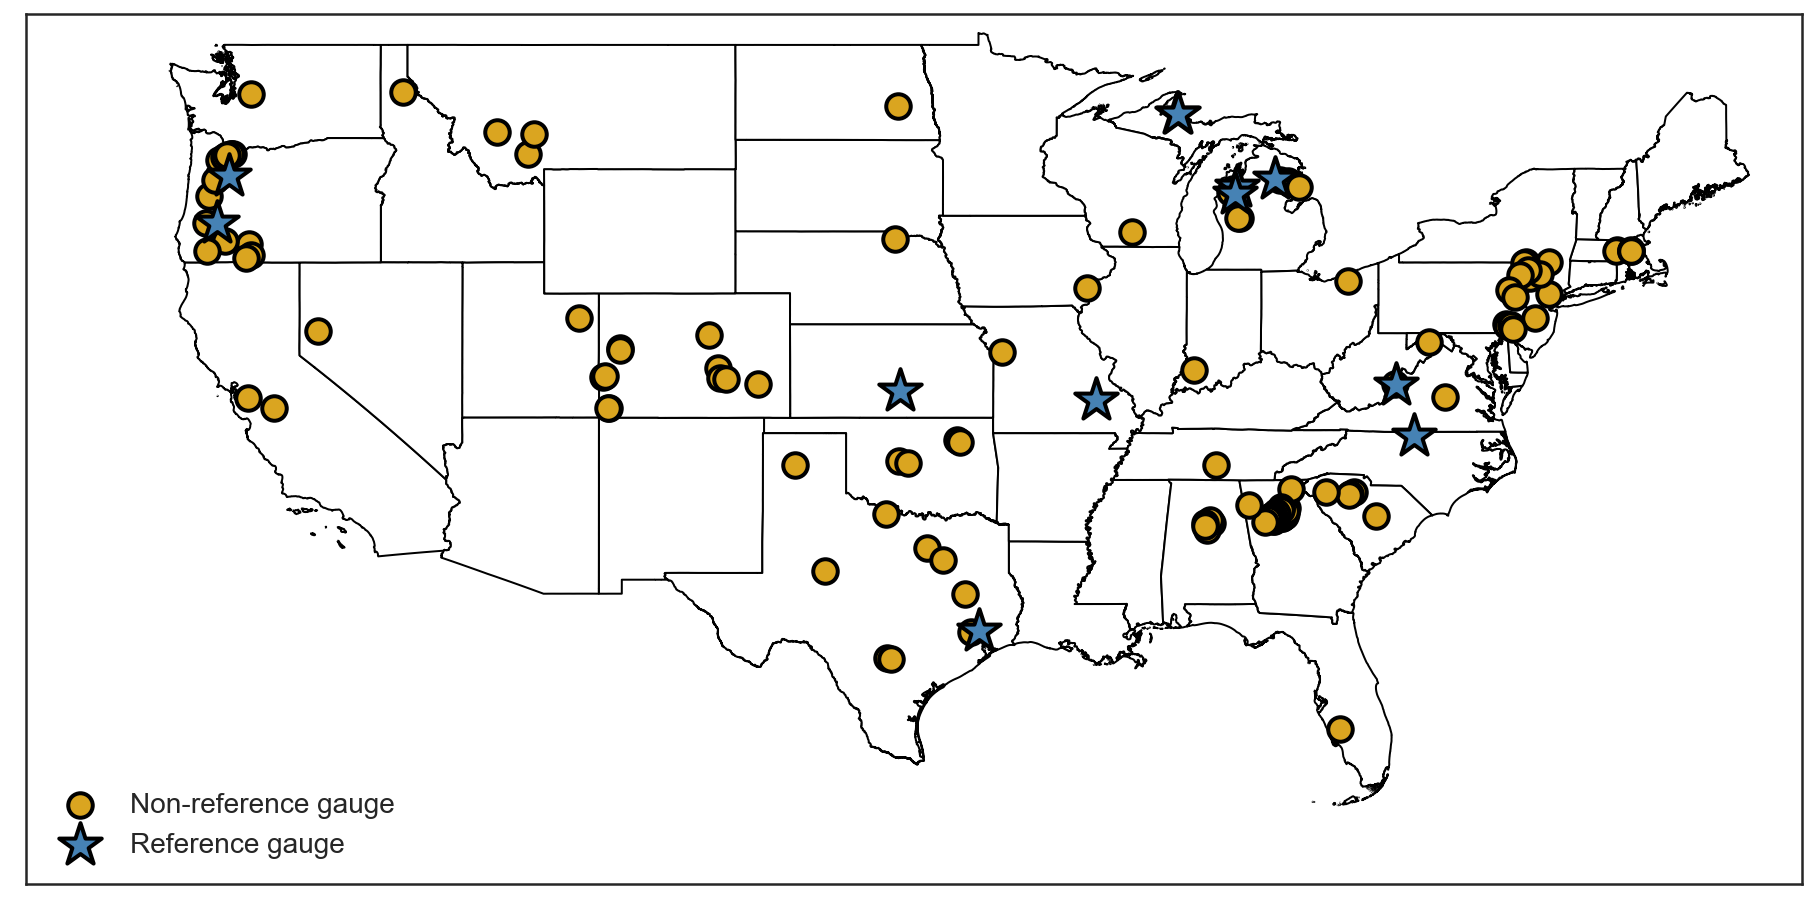

In [378]:
fig, ax = plt.subplots(1,figsize = (16,8))
cmap_use1 = 'viridis'

state_outline.plot(facecolor='white',edgecolors = 'k', ax=ax)
ax.set_xlim(-130,-65)
ax.set_ylim(22,50)
ax.set_xticks([])
ax.set_yticks([])


# ax.scatter(best_info_nonref.LNG_GAGE, best_info_nonref.LAT_GAGE, s=200, c=best_info_nonref.best_BFI, 
#           vmin = 0., vmax = 1, cmap = cmap_use1, edgecolor = 'k', 
#            label = 'Non-ref. gauge with {:1.0f}+ years continuous stream temperature record'.format(limit))

cm = ax.scatter(plot_stations[plot_stations.CLASS=='Non-ref'].LNG_GAGE, 
                plot_stations[plot_stations.CLASS=='Non-ref'].LAT_GAGE, s=150, edgecolor = 'k',#edgecolor = 'firebrick',lw = 2, 
           label = 'Non-reference gauge',c='goldenrod',lw=2)

# cm = ax.scatter(best_info_ref.LNG_GAGE,
#           best_info_ref.LAT_GAGE, s=500, c = best_info_ref.best_BFI,marker = '*',vmin = 0., vmax = 1,cmap = cmap_use1,
#           edgecolor = 'k', label ='reference gauge with {:1.0f}+ years continous stream temperature record'.format(limit))

ax.scatter(plot_stations[plot_stations.CLASS=='Ref'].LNG_GAGE,
          plot_stations[plot_stations.CLASS=='Ref'].LAT_GAGE, s=500, marker = '*',edgecolor = 'k',
#           edgecolor = 'firebrick', 
           lw=2, 
           label = 'Reference gauge',c='steelblue')


ax.legend(frameon=False,loc='lower left')

plt.savefig('../figures/monitoring_stations.pdf', format='pdf',bbox_inches = "tight")

In [384]:
# find median annual streamflow for each gage
limit=15
rlen = record_length[record_length.record_length_yr>limit]
median_streamflow = []
sites = []

print('total: ',len(rlen))
for k in range(len(rlen)):
    sitenum = str(int(rlen.iloc[k].site))
    while len(sitenum)<8:
        sitenum = '0'+sitenum
    print('')
    print(k, sitenum)
    
    # download streamflow and water temperature data from NWIS
    try:
        state_data = get_nwis(site=sitenum, service='iv', start_date=str(state_temp.index[0])[:10], 
                              end_date=str(state_temp.index[-1])[:10],parameterCd = '00060')
        state_data = extract_nwis_df(state_data)
        state_data_meta = state_data[1]
        state_data = state_data[0]
        state_data = state_data.rename(columns = {list(state_data.columns)[0]:'discharge_cfs',
                                      list(state_data.columns)[1]:'qualifiers'})
        state_data = state_data.merge(state_temp,left_index=True, right_index=True)
        median_streamflow.append(np.nanmedian(state_data.discharge_cfs))
        sites.append(sitenum)
    except:
        print('no data')

total:  311

0 02423130
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02423130&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

1 02423496
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02423496&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

2 02455980
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02455980&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

3 02457595
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02457595&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

4 02458450
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02458450&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

5 15081497
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=15081497&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

6 1


49 11467000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11467000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

50 11467600
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11467600&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
no data

51 11470500
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11470500&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
no data

52 11477000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11477000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

53 11480500
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11480500&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
no data

54 11516530
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11516530&parameterCd=00060&startDT=2007-10-01&end


99 02334430
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02334430&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

100 02334480
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02334480&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

101 02334578
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02334578&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

102 02334885
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02334885&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

103 02335000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02335000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

104 02335350
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=02335350&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

105 


149 06894000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=06894000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

150 07061270
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=07061270&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

151 06041000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=06041000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

152 06054500
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=06054500&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

153 06066500
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=06066500&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

154 12323770
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12323770&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

155


199 14139800
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14139800&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

200 14144900
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14144900&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01
no data

201 14145500
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14145500&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

202 14148000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14148000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

203 14150000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14150000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

204 14150300
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14150300&parameterCd=00060&startDT=2007-10-01&endDT=2021-01

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14366000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

249 14369500
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14369500&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

250 14372300
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=14372300&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

251 01427510
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01427510&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

252 01429000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01429000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

253 01447800
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01447800&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

254 01449360
Requ

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12116500&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

298 12117600
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12117600&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

299 12119000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12119000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

300 12147500
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12147500&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

301 12147600
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12147600&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

302 12148000
Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12148000&parameterCd=00060&startDT=2007-10-01&endDT=2021-01-01

303 12148300
Requ

In [386]:
median_flow_data = pd.DataFrame.from_dict({'site':sites,
                                           'median_streamflow':median_streamflow})
median_flow_data.to_csv('median_flows.csv',index=False)

Text(0, 0.5, 'Number of gages')

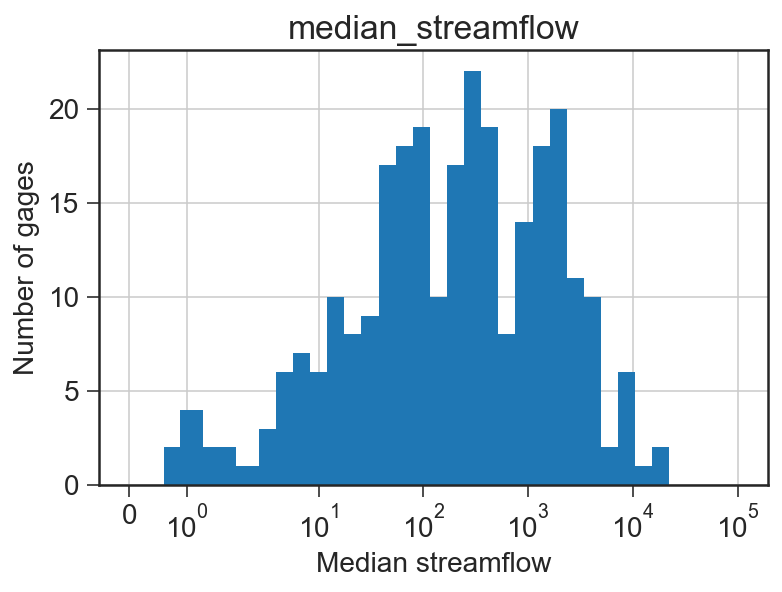

In [390]:
median_flow_data.hist(bins = np.logspace(-3,5))
plt.xscale('symlog')
plt.xlabel('Median streamflow')
plt.ylabel('Number of gages')

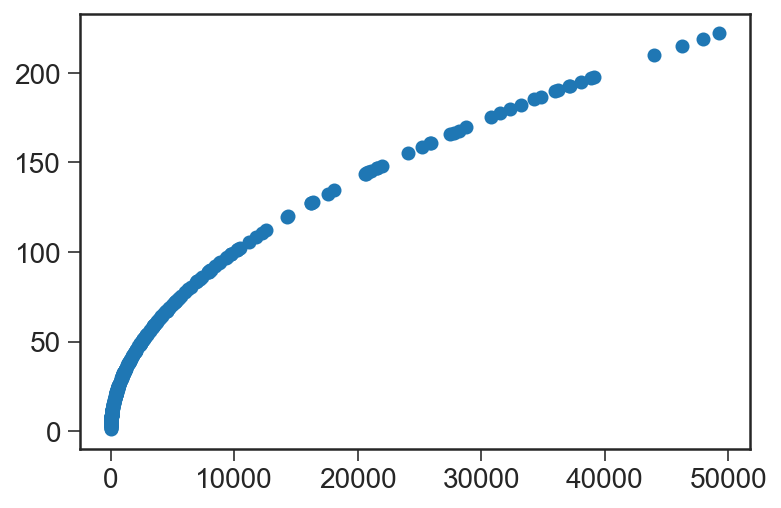

In [396]:
plt.scatter(gagesII.DRAIN_SQKM,((gagesII.DRAIN_SQKM*1000000)**0.5/1000))

In [397]:
gagesII[gagesII.STAID==11261500]

,STAID,STANAME,CLASS,AGGECOREGI,DRAIN_SQKM,HUC02,LAT_GAGE,LNG_GAGE,STATE,HCDN_2009,ACTIVE09,FLYRS1900,FLYRS1950,FLYRS1990,geometry
191,11261500,SAN JOAQUIN R A FREMONT FORD BRIDGE CA,Non-ref,WestXeric,21971.82,18,37.309939,-120.931037,CA,None,yes,45.0,33.0,8.0,POINT (-120.93104 37.30994)


Text(0.5, 0, 'BFI_max')

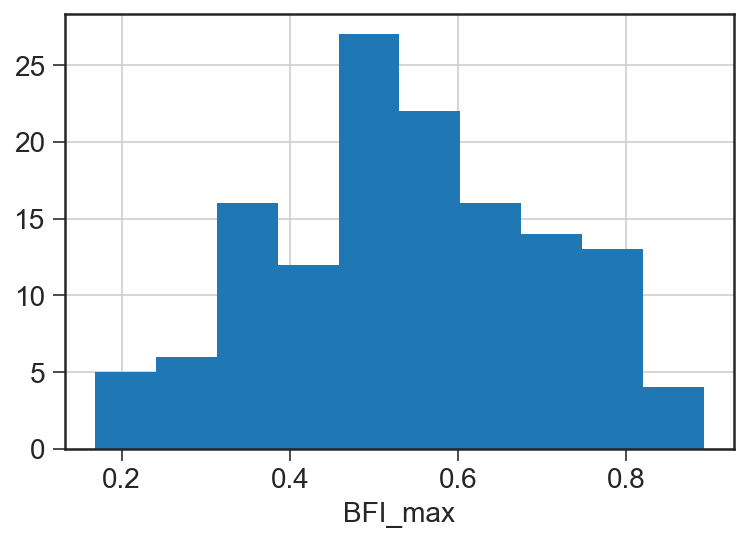

In [401]:
best_info_total.best_BFI.hist()
plt.xlabel('BFI_max')

In [404]:
median_flow_data.to_csv('../Data/median_streamflow.csv',index=False)

In [438]:
USGS_BFI = pd.read_csv('../Data/Ranked_OHS_Models.csv')
USGS_BFI['STAID'] = [USGS_BFI.STAID.values[i][1:-1] for i in range(len(USGS_BFI))]


In [439]:
# USGS_BFI['STAID'] = USGS_BFI.STAID.astype('float')
best_tmp = best_info_total.dropna()
best_tmp[['STAID_str']] = np.where(np.array([len(str(int(best_tmp.STAID.values[i]))) for i in range(len(best_tmp))])<8,
                                            ['0'+str(int(best_tmp.STAID.values[i])) for i in range(len(best_tmp))],
                                           [str(int(best_tmp.STAID.values[i])) for i in range(len(best_tmp))])
BFI_compare = best_tmp[['STAID_str','best_BFI']].merge(USGS_BFI[['STAID','ECK.CaF.BETA']],
                                           left_on='STAID_str',right_on='STAID',how='left').dropna()

<ipython-input-439-71838eb89628>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_tmp[['STAID_str']] = np.where(np.array([len(str(int(best_tmp.STAID.values[i]))) for i in range(len(best_tmp))])<8,
/Users/Dana/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Text(0, 0.5, 'USGS-calculated BFI_max')

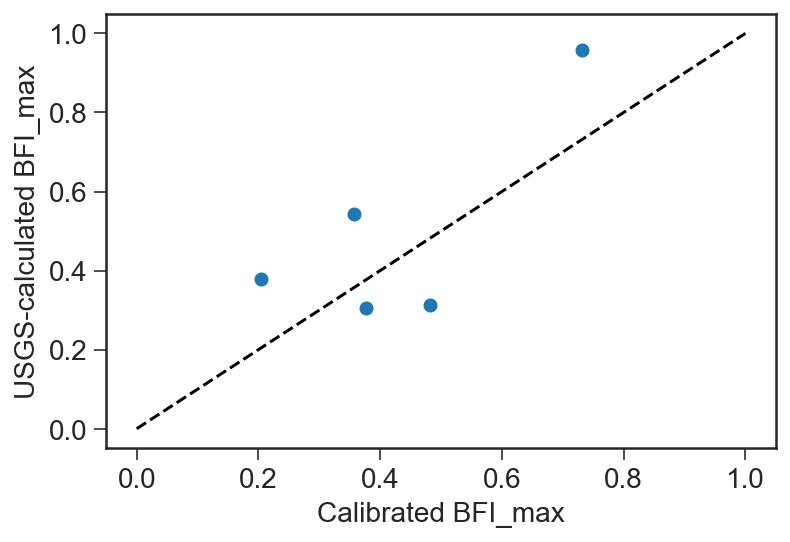

In [445]:
plt.scatter(BFI_compare.best_BFI, BFI_compare['ECK.CaF.BETA'])
plt.plot([0,1],[0,1],c='k',ls='--')
plt.xlabel('Calibrated BFI_max')
plt.ylabel('USGS-calculated BFI_max')